In [1]:
import sys
print(sys.path)
sys.path.append('/home/zinovyev/anaconda3/envs/geo_env/lib/python3.7/site-packages/')

['/mnt/c/MyPrograms/Python/COVID_model', '/home/zinovyev/anaconda3/envs/covid/lib/python310.zip', '/home/zinovyev/anaconda3/envs/covid/lib/python3.10', '/home/zinovyev/anaconda3/envs/covid/lib/python3.10/lib-dynload', '', '/home/zinovyev/anaconda3/envs/covid/lib/python3.10/site-packages']


In [2]:
from platform import python_version
python_version()
import geopandas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import scipy
from scipy.stats.mstats import winsorize
from scipy.stats import stats
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import silhouette_score
from tqdm import tqdm

import numpy as np
from skimage import color, io

from pycolormap_2d import ColorMap2DZiegler



from descartes import PolygonPatch
def plotCountryPatch( axes, country_name, fcolor ):
    # plot a country on the provided axes
    nami = world[world.name == country_name]
    namigm = nami.__geo_interface__['features']  # geopandas's geo_interface
    namig0 = {'type': namigm[0]['geometry']['type'], \
              'coordinates': namigm[0]['geometry']['coordinates']}
    axes.add_patch(PolygonPatch( namig0, fc=fcolor, ec="black", alpha=0.85, zorder=2 ))

/tmp/ipykernel_270/1582704073.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))


List of country names: ['Fiji', 'Tanzania', 'W. Sahara', 'Canada', 'United States of America', 'Kazakhstan', 'Uzbekistan', 'Papua New Guinea', 'Indonesia', 'Argentina', 'Chile', 'Dem. Rep. Congo', 'Somalia', 'Kenya', 'Sudan', 'Chad', 'Haiti', 'Dominican Rep.', 'Russia', 'Bahamas', 'Falkland Is.', 'Norway', 'Greenland', 'Fr. S. Antarctic Lands', 'Timor-Leste', 'South Africa', 'Lesotho', 'Mexico', 'Uruguay', 'Brazil', 'Bolivia', 'Peru', 'Colombia', 'Panama', 'Costa Rica', 'Nicaragua', 'Honduras', 'El Salvador', 'Guatemala', 'Belize', 'Venezuela', 'Guyana', 'Suriname', 'France', 'Ecuador', 'Puerto Rico', 'Jamaica', 'Cuba', 'Zimbabwe', 'Botswana', 'Namibia', 'Senegal', 'Mali', 'Mauritania', 'Benin', 'Niger', 'Nigeria', 'Cameroon', 'Togo', 'Ghana', "Côte d'Ivoire", 'Guinea', 'Guinea-Bissau', 'Liberia', 'Sierra Leone', 'Burkina Faso', 'Central African Rep.', 'Congo', 'Gabon', 'Eq. Guinea', 'Zambia', 'Malawi', 'Mozambique', 'eSwatini', 'Angola', 'Burundi', 'Israel', 'Lebanon', 'Madagascar', '

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


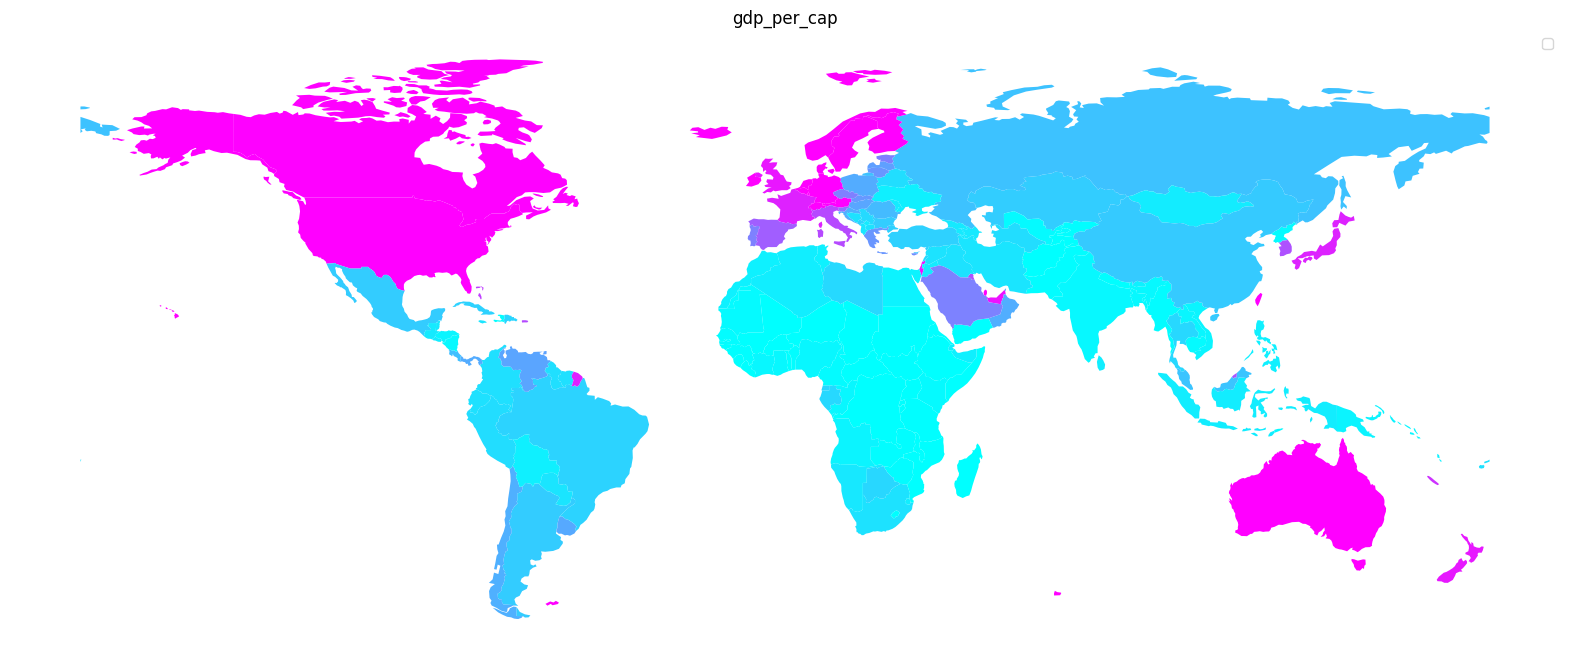

In [3]:
# Read world map

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.head()

print('List of country names:',list(world.name))

world = world[(world.pop_est>0) & (world.name!="Antarctica") & (world.name!="Greenland")]
world['gdp_per_cap'] = winsorize(world.gdp_md_est / world.pop_est * 1000000, limits=[0.1, 0.1])

world.plot(column='gdp_per_cap',figsize=(20,20),cmap='cool')
countries_gis = list(world['name'])
plt.title('gdp_per_cap')
plt.legend()
plt.axis('off')
plt.show()

In [12]:
# Loading data table and renaming some of the countries to make it consistent with geopandas
# Adding columns with logarithms of q and population 
# Filtering out countries with anomalous q value

tab = pd.read_csv('data/data.txt',sep='\t')
#display(tab)
q = tab['q'].to_numpy()
q_thresh = 1e6
#q_thresh = 1e100
#q_thresh = 50000
inds_excluded = np.where(q>q_thresh)[0]
inds = np.where(q<q_thresh)[0]
print('Outliers by q:')
display(tab.iloc[inds_excluded])
tab = tab.iloc[inds]
tab['logq'] = np.log10(tab['q'])
tab['log_population'] = np.log10(tab['Population'])

original_names = list(tab['Country'])
#print(original_names)

# Correct some names to make them compatible with geopandas
countries = list(tab['Country'])
countries[countries.index('Equatorial Guinea')] = 'Eq. Guinea'
countries[countries.index('Bosnia and Herzegovina')] = 'Bosnia and Herz.'
if 'Democratic Republic of Congo' in countries:
    countries[countries.index('Democratic Republic of Congo')] = 'Dem. Rep. Congo'
countries[countries.index('Dominican Republic')] = 'Dominican Rep.'
countries[countries.index('Central African Republic')] = 'Central African Rep.'
countries[countries.index('United States')] = 'United States of America'
countries[countries.index("Cote d'Ivoire")] = "Côte d'Ivoire"
countries[countries.index("South Sudan")] = "S. Sudan"
countries[countries.index("Eswatini")] = "eSwatini"
#countries[countries.index("Democratic Republic of Congo")] = "Dem. Rep. Congo"

tab['Country'] = countries

Outliers by q:


ISO_3 ISO_2 Continent                  Region  Population  LogPopulation  \
0   VNM    VN      Asia  Asia excl. Middle East    97338583          7.988   
1   TLS    TL      Asia  Asia excl. Middle East     1318442          6.120   
2   TWN    TW      Asia  Asia excl. Middle East    23816775          7.377   
3   UGA    UG    Africa      Africa excl. North    45741000          7.660   

   Threshold  Ndays  Country  GDP_per_capita_PPP       a     K2            q  \
0         17    150  Vietnam              8650.1  0.2934   6.26  174924550.0   
1          1    300    Timor              4141.3  0.3261   2.82    3693710.0   
2         10    300   Taiwan             55724.0  0.2281   3.92    3602440.0   
3         10    150   Uganda              2294.3  0.1503  25.59    2931510.0   

       logq    Io       R2  
0  8.242851  0.06  0.95530  
1  6.567463  0.05  0.96226  
2  6.556597  0.01  0.99495  
3  6.467091  0.15  0.98450

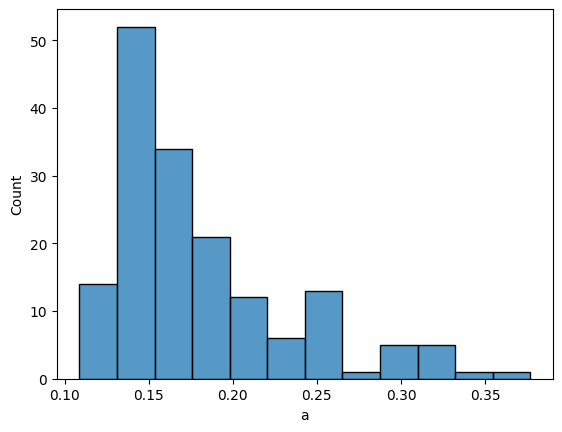

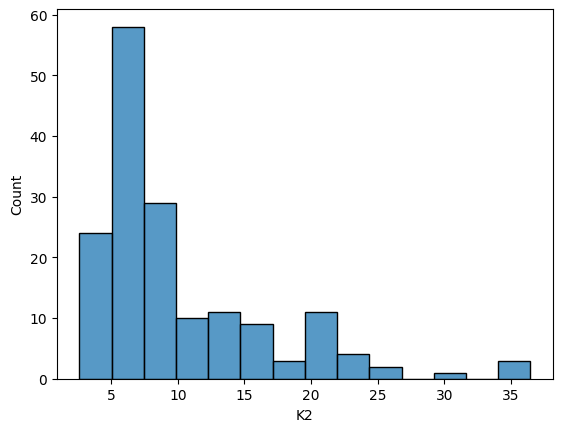

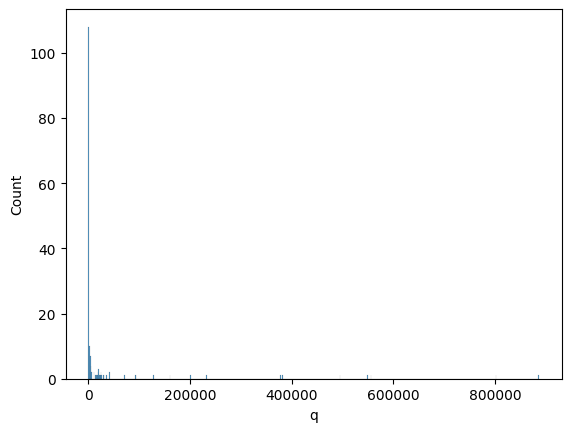

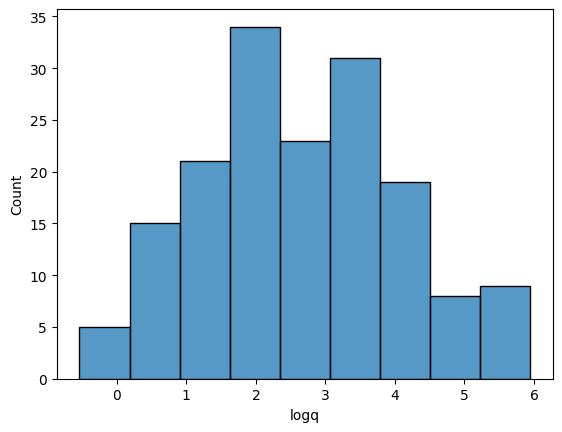

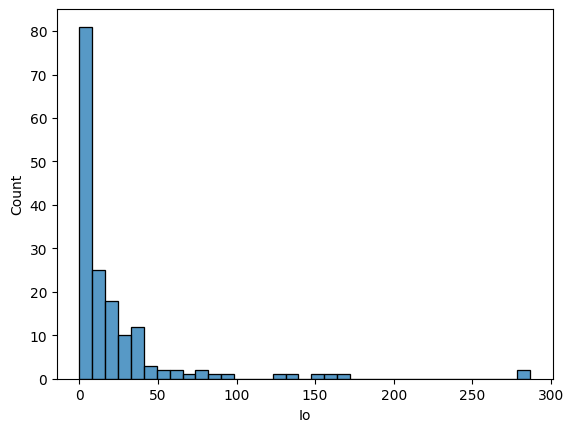

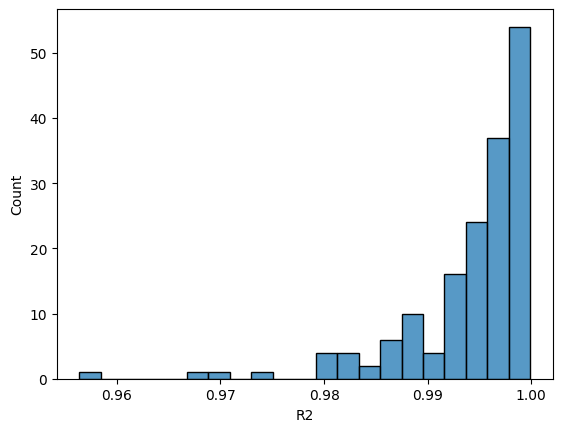

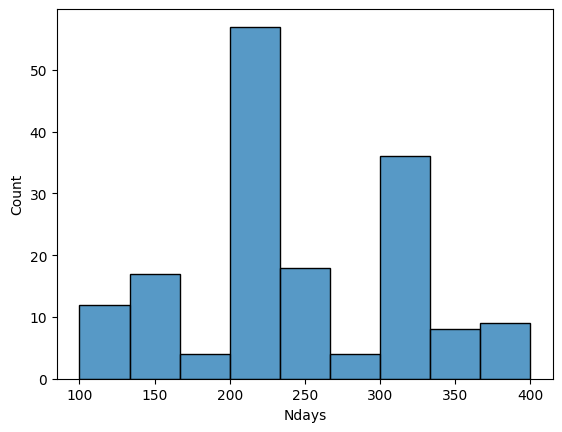

<Axes: xlabel='GDP_per_capita_PPP', ylabel='Count'>

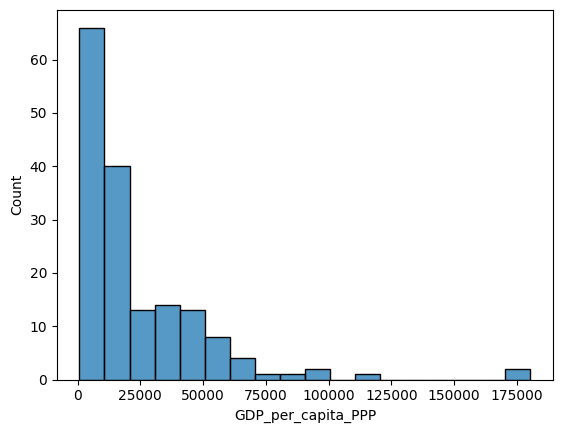

In [13]:
# Plot parameter histograms

sn.histplot(data=tab,x='a')
plt.show()
sn.histplot(data=tab,x='K2')
plt.show()
sn.histplot(data=tab,x='q')
plt.show()
sn.histplot(data=tab,x='logq')
plt.show()
sn.histplot(data=tab,x='Io')
plt.show()
sn.histplot(data=tab,x='R2')
plt.show()
sn.histplot(data=tab,x='Ndays')
plt.show()
sn.histplot(data=tab,x='GDP_per_capita_PPP')

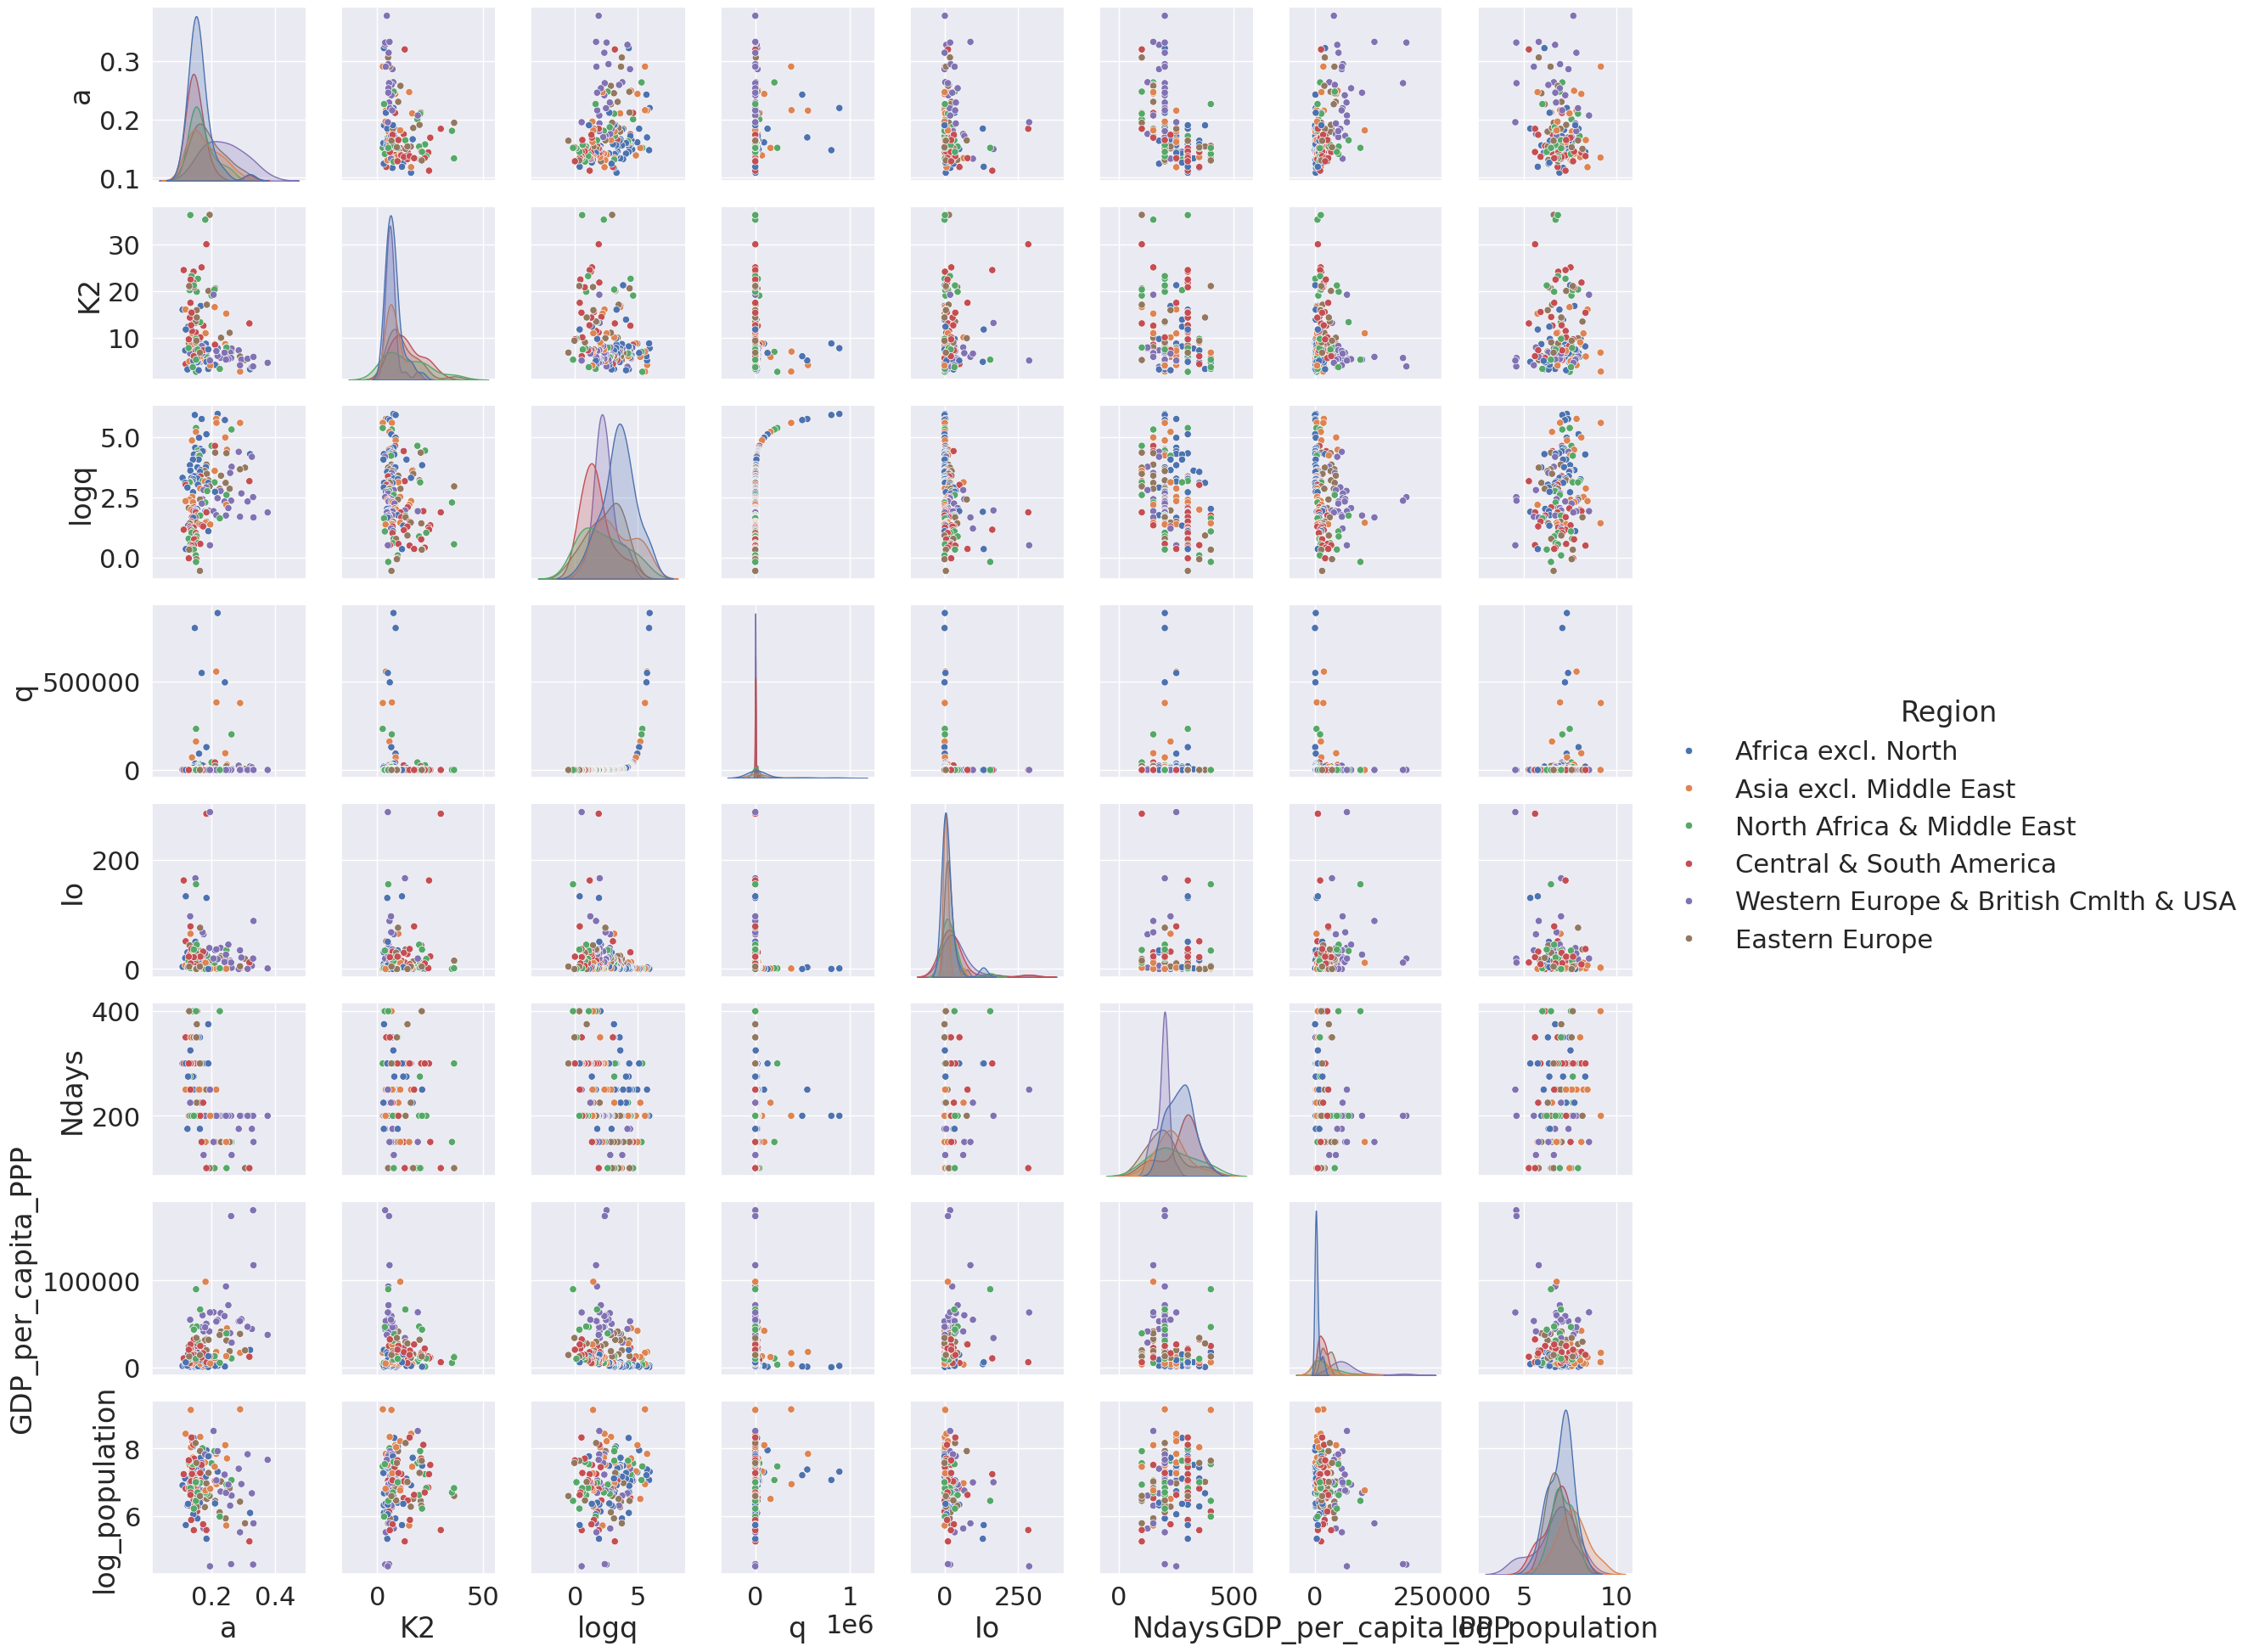

In [14]:
# Plot pairwise plots of parameter values

sn.set(font_scale=2)
sn.pairplot(data=tab[['Region','a','K2','logq','q','Io','Ndays','GDP_per_capita_PPP','log_population']],hue='Region')
plt.show()

In [17]:
# Make country isocode mapping and correct some codes manually

#isocodes = pd.read_csv('data/country_isocodes.txt',sep='\t')
#countries_iso = list(isocodes['COUNTRY'])
#countries_iso2 = list(isocodes['ISO2'])
countries_iso2 = list(tab['ISO_2'])
mapcodes = {row['Country']:row['ISO_2'] for i,row in tab.iterrows()}

mapcodes['Bosnia and Herz.'] = 'BA'
mapcodes['Central African Rep.'] = 'CF'
mapcodes['Dominican Rep.'] = 'DO'
mapcodes['Eq. Guinea'] = 'GQ'
mapcodes['eSwatini'] = 'SZ'
mapcodes['Kosovo'] = 'KS'
mapcodes['S. Sudan'] = 'SD'
mapcodes['Dem. Rep. Congo'] = 'CD'
codes = [mapcodes[c] for c in countries]
#tab['ISO2'] = codes
#tab.to_csv('output/data4.txt',sep='\t',index=False)

In [18]:
# Map parameter values onto the geographic map

map_a = {}
map_K2 = {}
map_logq = {}
map_GDPcap = {}
for cgis in countries_gis:
    ii = -1
    for i,c in enumerate(countries):
        if cgis==c:
            a = np.float64(tab.loc[tab['Country']==c].a)
            K2 = np.float64(tab.loc[tab['Country']==c].K2)
            logq = np.float64(tab.loc[tab['Country']==c].logq)
            GDPcap = np.float64(tab.loc[tab['Country']==c].GDP_per_capita_PPP)
            map_a[c] = a
            map_K2[c] = K2
            map_logq[c] = logq
            map_GDPcap[c] = GDPcap
            #print(c,a,K2,logq)
for cgis in countries_gis:
    if not cgis in map_a:
        map_a[cgis] = np.nan
        map_K2[cgis] = np.nan
        map_logq[cgis] = np.nan
        map_GDPcap[cgis] = np.nan
            
list_a = [map_a[c] for c in countries_gis]
list_K2 = [map_K2[c] for c in countries_gis]
list_logq = [map_logq[c] for c in countries_gis]
list_GDPcap = [map_GDPcap[c] for c in countries_gis]
world['a'] = list_a
world['K2'] = list_K2
world['logq'] = list_logq
world['GDPcap'] = list_GDPcap

# Uncomment for shozing the table
# display(world)

# Sanity check that the data for GDP in geopandas is the approximately the same as in the input table
# sn.scatterplot(data=world,x='gdp_per_cap',y='GDPcap')

/tmp/ipykernel_270/3078777067.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  a = np.float64(tab.loc[tab['Country']==c].a)
/tmp/ipykernel_270/3078777067.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  K2 = np.float64(tab.loc[tab['Country']==c].K2)
/tmp/ipykernel_270/3078777067.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  logq = np.float64(tab.loc[tab['Country']==c].logq)
/tmp/ipykernel_270/3078777067.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  GDPcap = np.float64(tab.loc[tab['Country']==c].GDP_per_capita_PPP)


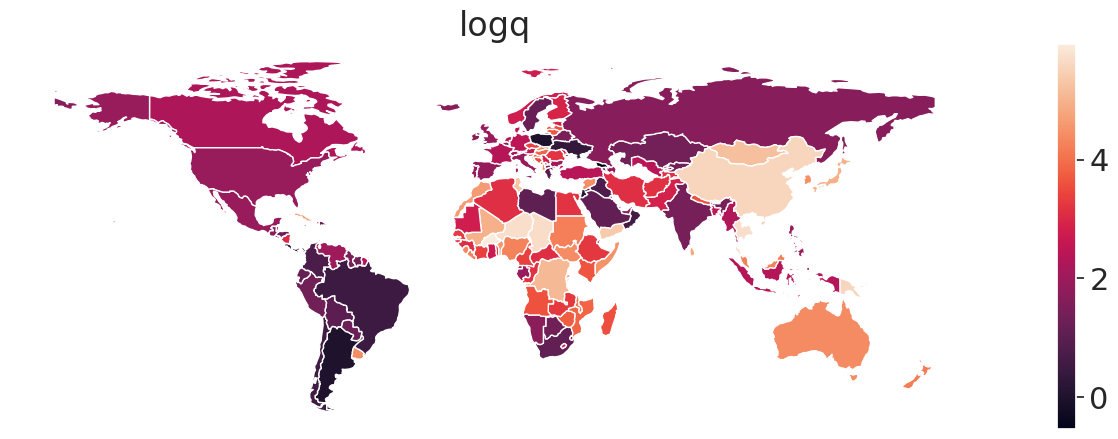

In [28]:
# Plot individual parameters on top of the geographical map

# Uncomment the column for visualization
#col = 'logq'
#col = 'GDPcap'
#col = 'gdp_per_cap'
col = 'a'
col = 'K2'
col = 'logq'
world.plot(column=col,figsize=(20,5), legend=True)
#world.plot(column=col,figsize=(20,20))
plt.axis('off')
plt.title(col)
plt.show()

In [101]:
print(color.lab2rgb([[33.54000792950888, -104.50278416096356, 53.57535200091286]]))

[[0.         0.40541624 0.        ]]


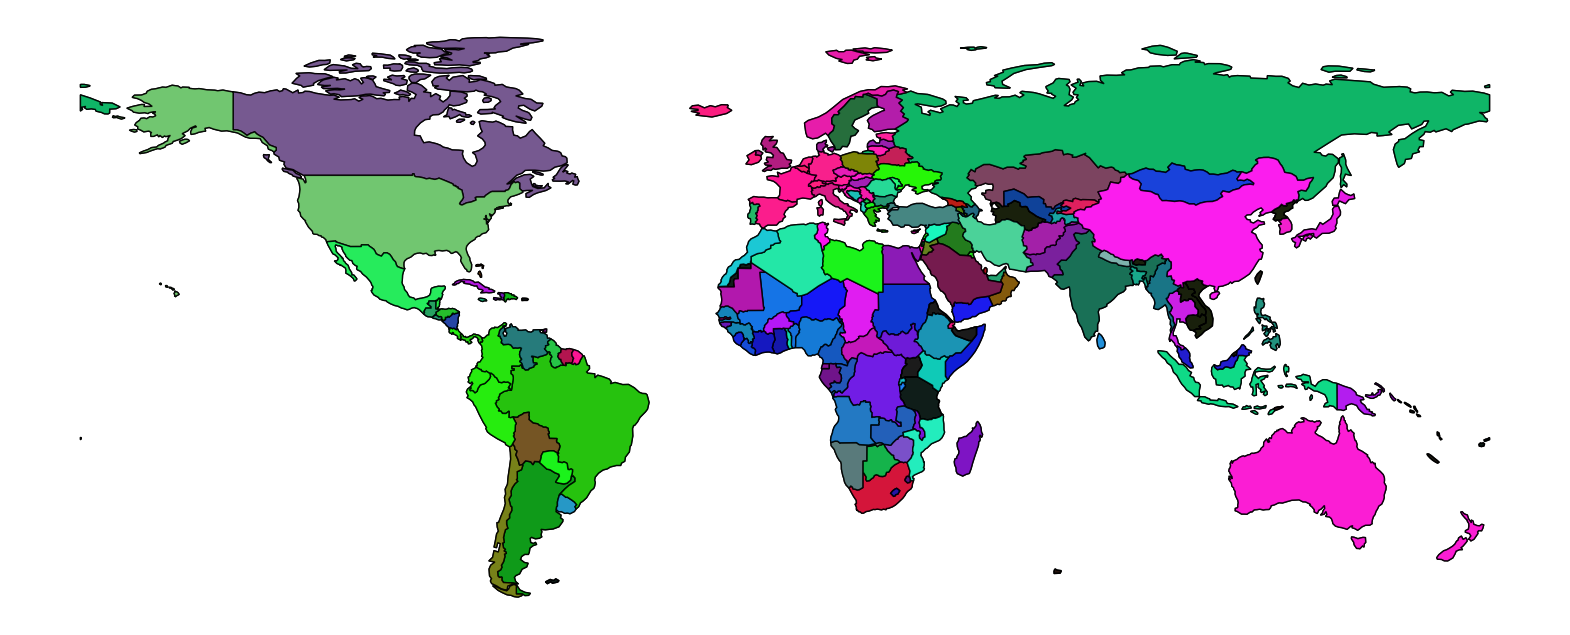

In [29]:
# "Three-dimensional" coloring Red=a, Green=K2, Blue=logq

a = winsorize(np.array(list_a),limits=(0.1,0.1))
a = a[np.where(1-np.isnan(a))]
a_mx = np.max(a)
a_mn = np.min(a)

K2 = winsorize(np.array(list_K2),limits=(0.1,0.1))
K2 = K2[np.where(1-np.isnan(K2))]
K2_mx = np.max(K2)
K2_mn = np.min(K2)

logq = winsorize(np.array(list_logq),limits=(0.1,0.1))
logq = logq[np.where(1-np.isnan(logq))]
logq_mx = np.max(logq)
logq_mn = np.min(logq)

# One can focus on a predefined subset of countries or an explicitly specified subset, 
# if this is needed: uncomment the corresponding line and comment the next one
ax2 = world.plot( figsize=(20,20), edgecolor=u'black', cmap='Set2' )

#ax2 = world[world.continent == 'Africa'].plot(figsize=(8,8), edgecolor=u'gray', cmap='Pastel1')
#ax2 = world[world.continent == 'North America'].plot(figsize=(20,20), edgecolor=u'black', cmap='Pastel1')
#ax2 = world[world.continent == 'South America'].plot(figsize=(20,20), edgecolor=u'black', cmap='Pastel1')
#ax2 = world[world.continent == 'Oceania'].plot(figsize=(20,20), edgecolor=u'black', cmap='Pastel1')
#ax2 = world[world.continent == 'Asia'].plot(figsize=(20,20), edgecolor=u'black', cmap='Pastel1')

# visualizing a subset
#selection = world.continent == 'Europe'
#selection[world.name == 'Russia'] = False
#ax2 = world[selection].plot(figsize=(20,20), edgecolor=u'gray', cmap='Pastel1')


for c in countries_gis:
    a = (map_a[c]-a_mn)/(a_mx-a_mn)
    K2 = (map_K2[c]-K2_mn)/(K2_mx-K2_mn)
    logq = (map_logq[c]-logq_mn)/(logq_mx-logq_mn)
    if np.isnan(a):
        plotCountryPatch(ax2, c, 'black')
    else:
        #plotCountryPatch(ax2, c, [a,K2,logq])
        #print(color.lab2rgb([a,K2,logq]))
        #plotCountryPatch(ax2, c, color.lab2rgb(np.array([a*99,K2*250-120,logq*250-120])))
        plotCountryPatch(ax2, c, color.xyz2rgb(np.array([a,K2,logq])))
        #plotCountryPatch(ax2, c, [1-a,1-K2,1-logq])
    
plt.axis('off')
plt.show()

/tmp/ipykernel_270/3809120966.py:6: DeprecationWarning: Please use `zscore` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  X = stats.zscore(X)


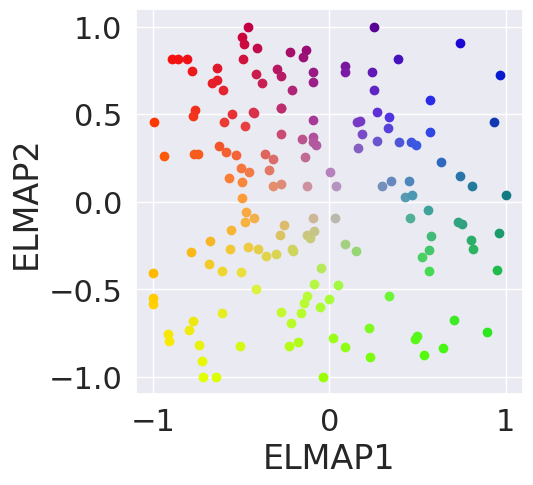

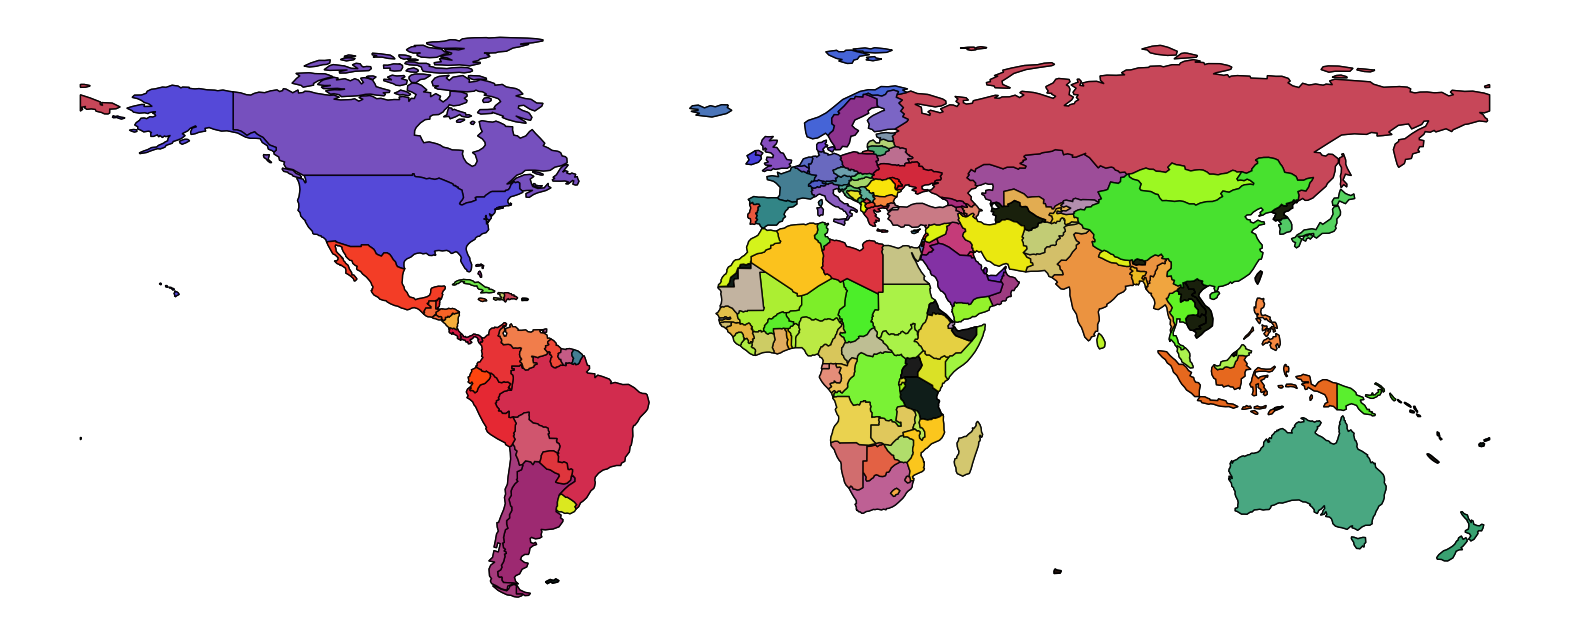

In [30]:
# Loading the coordinates on the elastic map, and create "two-dimensional" coloring
# where countries with close projections on elastic map have similar color

coords = np.loadtxt('data/dataproj_4vars.vem')
X = tab[['a','K2','logq','GDP_per_capita_PPP']].to_numpy()
X = stats.zscore(X)

cmap = ColorMap2DZiegler(range_x=(-1.0, 1.0), range_y=(-1.0, 1.0))

fig = plt.figure(figsize=(5,5))
for i in range(coords.shape[0]):
    plt.scatter(coords[i,0],coords[i,1],c=[np.array(cmap(coords[i,0],coords[i,1]))/255])
plt.xlabel('ELMAP1')
plt.ylabel('ELMAP2')
plt.show()

Xw = winsorize(X,axis=0,limits=[0.1,0.1])
mn = np.min(Xw,axis=0)
mx = np.max(Xw,axis=0)

map_countries = {}
for cgis in countries_gis:
    ii = -1
    for i,c in enumerate(countries):
        if cgis==c:
            map_countries[c] = i
for cgis in countries_gis:
    if not cgis in map_countries:
        map_countries[cgis] = np.nan
            
list_countries = [map_countries[c] for c in countries_gis]

ax2 = world.plot( figsize=(20,20), edgecolor=u'black', cmap='Set2' )
#selection = world.continent == 'Europe'
#selection[world.name == 'Russia'] = False
#ax2 = world[selection].plot(figsize=(20,20), edgecolor=u'gray', cmap='Pastel1')
#ax2 = world[world.continent == 'Africa'].plot(figsize=(8,8), edgecolor=u'gray', cmap='Pastel1')
#ax2 = world[world.continent == 'North America'].plot(figsize=(20,20), edgecolor=u'black', cmap='Pastel1')
#ax2 = world[world.continent == 'South America'].plot(figsize=(20,20), edgecolor=u'black', cmap='Pastel1')
#ax2 = world[world.continent == 'Oceania'].plot(figsize=(20,20), edgecolor=u'black', cmap='Pastel1')
#ax2 = world[world.continent == 'Asia'].plot(figsize=(20,20), edgecolor=u'black', cmap='Pastel1')

for c in countries_gis:
    if np.isnan(map_countries[c]):
        plotCountryPatch(ax2, c, 'black')
    else:
        #a = (Xw[map_countries[c],0]-mn[0])/(mx[0]-mn[0])
        #K2 = (Xw[map_countries[c],1]-mn[1])/(mx[1]-mn[1])
        #logq = (Xw[map_countries[c],2]-mn[2])/(mx[2]-mn[2])
        i = map_countries[c]
        x = coords[i,0]
        y = coords[i,1]
        plotCountryPatch(ax2, c, np.array(cmap(x,y))/255)

plt.axis('off')
plt.show()

Shape of the PCA matrix: (165, 3)


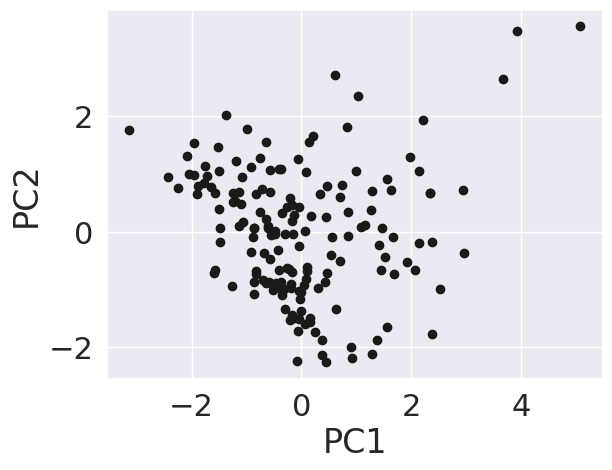

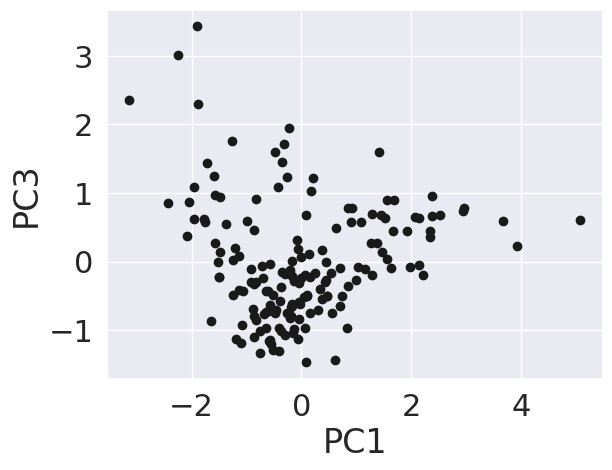

In [31]:
# Compute PCA for the dataset
pca = PCA(n_components=3)
u = pca.fit_transform(X)
print('Shape of the PCA matrix:',u.shape)
plt.plot(u[:,0],u[:,1],'ko')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()
plt.plot(u[:,0],u[:,2],'ko')
plt.xlabel('PC1')
plt.ylabel('PC3')
plt.show()

/tmp/ipykernel_270/560479643.py:8: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(pc1,pc2,c=color.lab2rgb(v))
/tmp/ipykernel_270/560479643.py:8: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1 negative Z values that have been clipped to zero
  plt.scatter(pc1,pc2,c=color.lab2rgb(v))


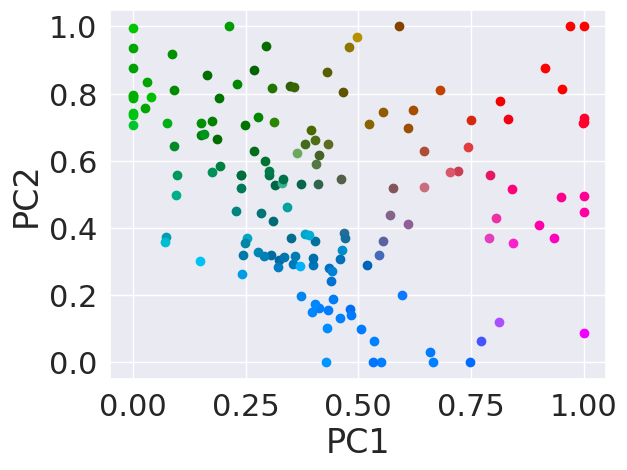

/tmp/ipykernel_270/560479643.py:20: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(pc1,pc3,c=color.lab2rgb(v))
/tmp/ipykernel_270/560479643.py:20: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1 negative Z values that have been clipped to zero
  plt.scatter(pc1,pc3,c=color.lab2rgb(v))


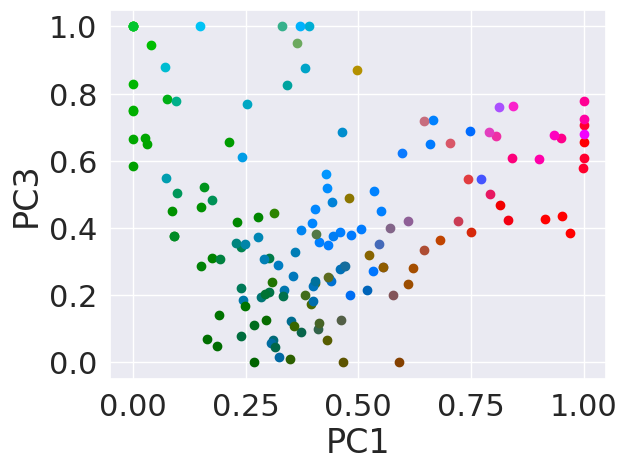

In [106]:
for c in countries_gis:
    if not np.isnan(map_countries[c]):
        pc1 = u[map_countries[c],0]
        pc2 = u[map_countries[c],1]
        pc3 = u[map_countries[c],2]
        v = [35+pc3*30.0,pc1*255.0-127.0,pc2*255.0-127.0]
        #print(c,[pc1,pc2,pc3],v,color.lab2rgb(v,illuminant="A"))
        plt.scatter(pc1,pc2,c=color.lab2rgb(v))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

for c in countries_gis:
    if not np.isnan(map_countries[c]):
        pc1 = u[map_countries[c],0]
        pc2 = u[map_countries[c],1]
        pc3 = u[map_countries[c],2]
        v = [35+pc3*30.0,pc1*255.0-127.0,pc2*255.0-127.0]
        #print(c,[pc1,pc2,pc3],v,color.lab2rgb(v,illuminant="A"))
        plt.scatter(pc1,pc3,c=color.lab2rgb(v))
plt.xlabel('PC1')
plt.ylabel('PC3')
plt.show()


mn= [-1.88484096 -2.11372158 -1.3363749 ]
mx= [2.34499124 1.78072013 1.59834511]


/tmp/ipykernel_270/4038063955.py:59: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1 negative Z values that have been clipped to zero
  plotCountryPatch(ax2, c, color.lab2rgb(v,illuminant="D65"))
/tmp/ipykernel_270/4038063955.py:59: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1 negative Z values that have been clipped to zero
  plotCountryPatch(ax2, c, color.lab2rgb(v,illuminant="D65"))
/tmp/ipykernel_270/4038063955.py:59: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1 negative Z values that have been clipped to zero
  plotCountryPatch(ax2, c, color.lab2rgb(v,illuminant="D65"))
/tmp/ipykernel_270/4038063955.py:59: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1 negative Z values that have been clipped to zero
  plotCountryPatch(ax2, c, color.lab2rgb(v,illuminant="D65"))
/tmp/ipykernel_270/4038063955.py:59: UserWarning: Conversion from CIE-LAB, via XYZ to sR

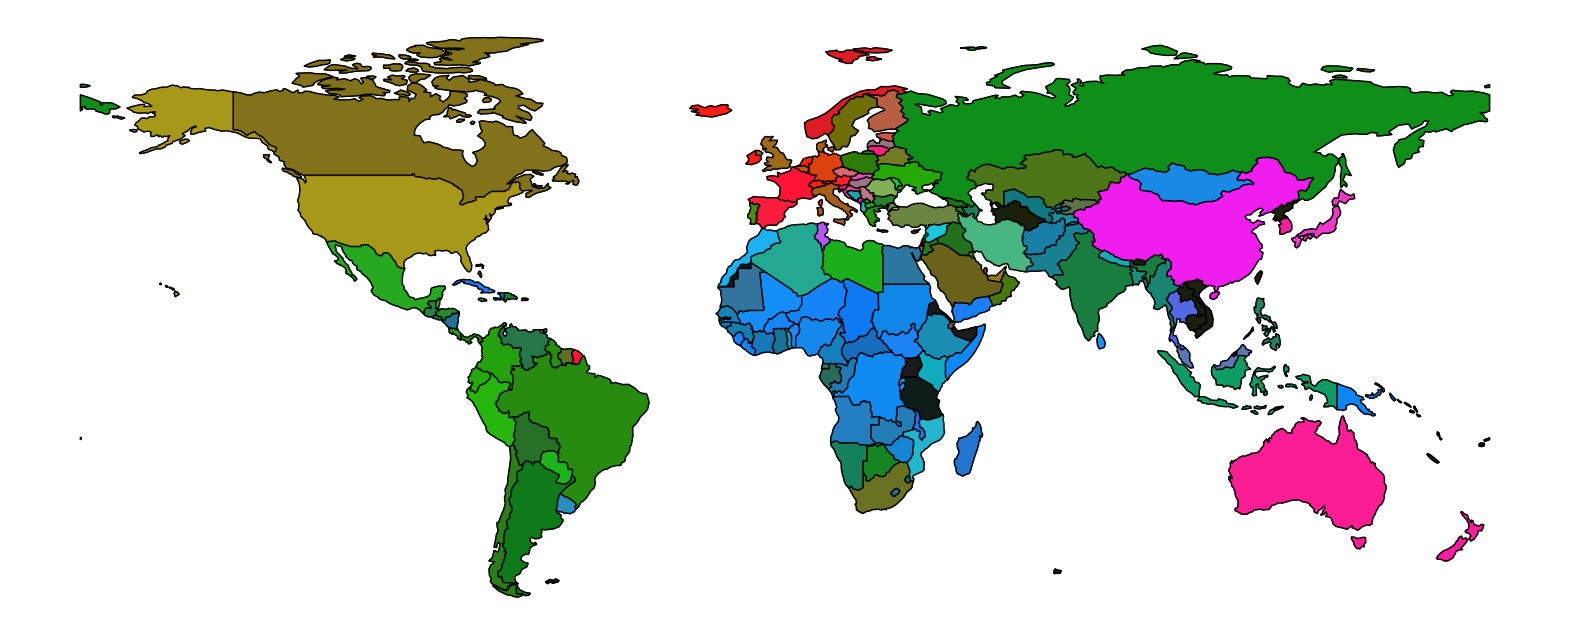

In [107]:
# Create "Three-dimensional" PCA coloring 

pca = PCA(n_components=3)
u = pca.fit_transform(X)
wins_limit = 0.05
u[:,0] = winsorize(u[:,0],limits=[wins_limit,wins_limit])
u[:,1] = winsorize(u[:,1],limits=[wins_limit/2,wins_limit])
u[:,2] = winsorize(u[:,2],limits=[wins_limit/4,wins_limit])
mn = np.min(u,axis=0)
mx = np.max(u,axis=0)

print('mn=',mn)
print('mx=',mx)

map_countries = {}
for cgis in countries_gis:
    ii = -1
    for i,c in enumerate(countries):
        if cgis==c:
            map_countries[c] = i
for cgis in countries_gis:
    if not cgis in map_countries:
        map_countries[cgis] = np.nan
            
list_countries = [map_countries[c] for c in countries_gis]

for i in range(3):
    u[:,i] = (u[:,i]-mn[i])/(mx[i]-mn[i])

tab['PC1'] = u[:,0]*255
tab['PC2'] = u[:,1]*255
tab['PC3'] = u[:,2]*255

#display(tab.loc[tab['ISO2'].isin(['US','LB','GR','BE','GB'])])

ax2 = world.plot( figsize=(20,20), edgecolor=u'black', cmap='Set2' )
#selection = world.continent == 'Europe'
#selection[world.name == 'Russia'] = False
#ax2 = world[selection].plot(figsize=(20,20), edgecolor=u'gray', cmap='Pastel1')
#ax2 = world[world.continent == 'Africa'].plot(figsize=(8,8), edgecolor=u'gray', cmap='Pastel1')
#ax2 = world[world.continent == 'North America'].plot(figsize=(20,20), edgecolor=u'black', cmap='Pastel1')
#ax2 = world[world.continent == 'South America'].plot(figsize=(20,20), edgecolor=u'black', cmap='Pastel1')
#ax2 = world[world.continent == 'Oceania'].plot(figsize=(20,20), edgecolor=u'black', cmap='Pastel1')
#ax2 = world[world.continent == 'Asia'].plot(figsize=(20,20), edgecolor=u'black', cmap='Pastel1')

for c in countries_gis:
    if np.isnan(map_countries[c]):
        plotCountryPatch(ax2, c, 'black')
    else:
        #pc1 = (u[map_countries[c],0]-mn[0])/(mx[0]-mn[0])
        #pc2 = (u[map_countries[c],1]-mn[1])/(mx[1]-mn[1])
        #pc3 = (u[map_countries[c],2]-mn[2])/(mx[2]-mn[2])
        pc1 = u[map_countries[c],0]
        pc2 = u[map_countries[c],1]
        pc3 = u[map_countries[c],2]
        v = [35+pc3*30.0,pc1*255.0-127.0,pc2*255.0-127.0]
        #plotCountryPatch(ax2, c, color.xyz2rgb([pc1,pc2,pc3]))
        #print(c,[pc1,pc2,pc3],[pc1*99.0,pc2*250.0-127.0,pc3*250.0-127.0],color.lab2rgb([pc1*99.0,pc2*250.0-127.0,pc3*250.0-127.0],illuminant="A"))
        plotCountryPatch(ax2, c, color.lab2rgb(v,illuminant="D65"))

plt.axis('off')
plt.show()

/tmp/ipykernel_270/3152918450.py:14: DeprecationWarning: Please use `zscore` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  X = stats.zscore(X)


165


100%|███████████████████████████████████████████████████████████████████████████████████| 18/18 [00:44<00:00,  2.46s/it]


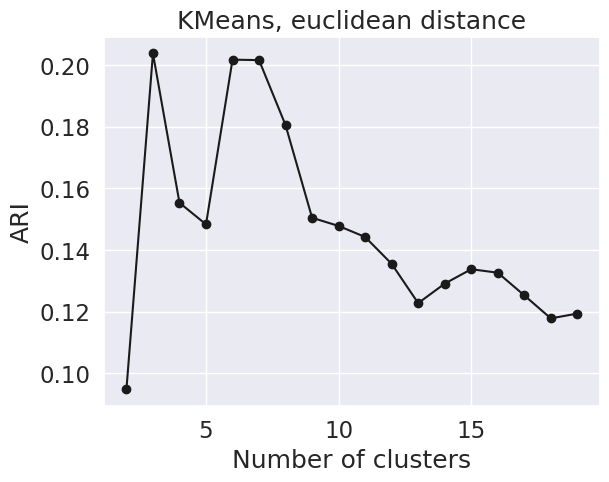

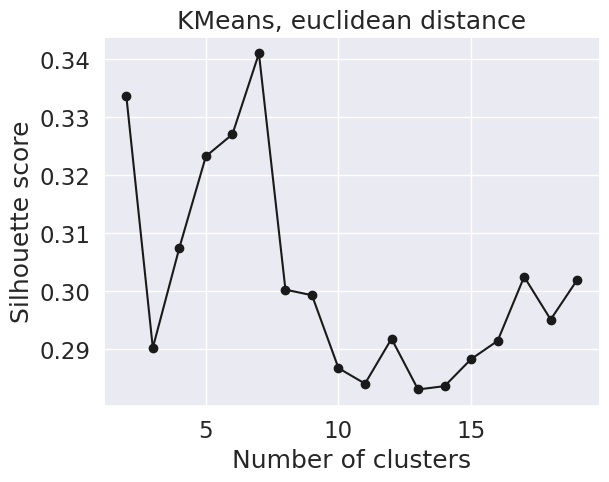

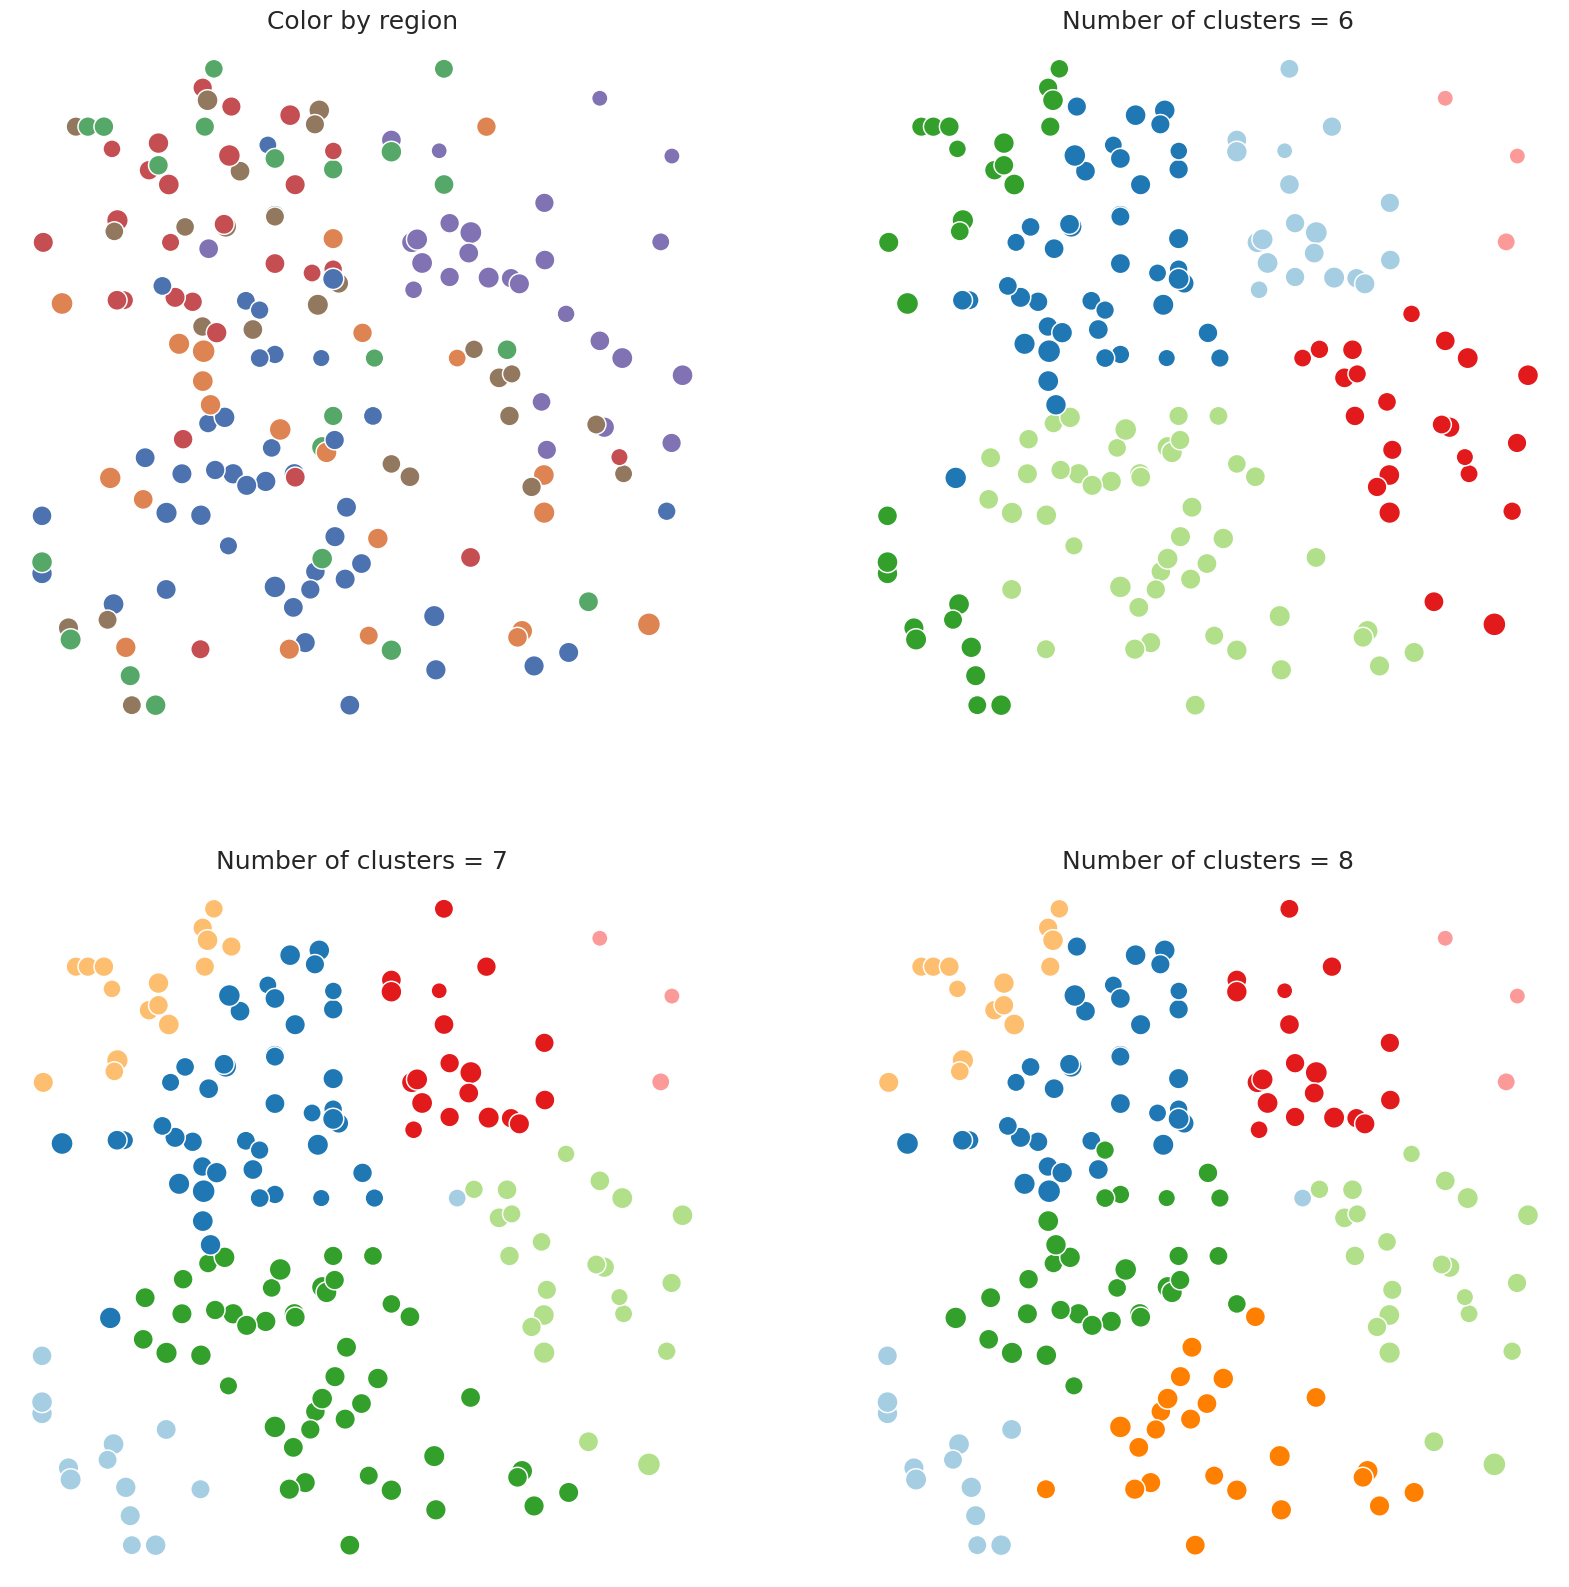

In [109]:
# Perform clustering and compute clustering quality criteria

classes = list(tab['Region'])
print(len(classes))
logpop = np.array(list(tab['log_population']))

#coords = np.loadtxt('/mnt/c/Datas/COVID_model/data2_proj.txt')
#X = tab[['a','K2','logq']].to_numpy()
#coords = np.loadtxt('/mnt/c/Datas/COVID_model/data1_proj.txt')
#X = tab[['a','K2','logq','Io','Ndays']].to_numpy()
coords = np.loadtxt('data/dataproj_4vars.vem')
X = tab[['a','K2','logq','GDP_per_capita_PPP']].to_numpy()

X = stats.zscore(X)
aris_kmeans_euclidean = []
sil_kmeans_euclidean = []
labels_kmeans_euclidean = []
nclusters = np.arange(2,20)
for nc in tqdm(nclusters):
    kmeans = KMeans(n_clusters=nc, random_state=0,n_init=1000).fit(X)
    labels_kmeans_euclidean.append(kmeans.labels_)
    ari = adjusted_rand_score(classes,kmeans.labels_)
    sil = silhouette_score(X,kmeans.labels_)
    aris_kmeans_euclidean.append(ari)
    sil_kmeans_euclidean.append(sil)
    
sn.set(font_scale=1.5)
plt.plot(nclusters,aris_kmeans_euclidean,'ko-')
plt.xlabel('Number of clusters')
plt.title('KMeans, euclidean distance')
plt.ylabel('ARI')
plt.show()

sn.set(font_scale=1.5)
plt.plot(nclusters,sil_kmeans_euclidean,'ko-')
plt.xlabel('Number of clusters')
plt.title('KMeans, euclidean distance')
plt.ylabel('Silhouette score')
plt.show()

#sn.scatterplot(data={'x':coords[:,0],'y':coords[:,1],'logpop':logpop,'Region':classes},size='logpop',color='Region')
sn.set(font_scale=1.5)
fig, ax = plt.subplots(2,2,figsize=(20,20))
plt.subplot(221)
sn.scatterplot(data={'x':coords[:,0],'y':coords[:,1],'logpop':logpop,'Region':classes},x='x',y='y',hue='Region',legend=False,s=logpop*30)
plt.axis('off')
plt.title('Color by region')

num = 6
k = np.where(nclusters==num)[0][0]
plt.subplot(222)
sn.scatterplot(data={'x':coords[:,0],'y':coords[:,1],'logpop':logpop,'Region':classes,'cluster':labels_kmeans_euclidean[k]},x='x',y='y',hue='cluster',legend=False,s=logpop*30,palette='Paired')
plt.axis('off')
plt.title('Number of clusters = '+str(num))

num = 7
k = np.where(nclusters==num)[0][0]
plt.subplot(223)
sn.scatterplot(data={'x':coords[:,0],'y':coords[:,1],'logpop':logpop,'Region':classes,'cluster':labels_kmeans_euclidean[k]},x='x',y='y',hue='cluster',legend=False,s=logpop*30,palette='Paired')
plt.axis('off')
plt.title('Number of clusters = '+str(num))

num = 8
k = np.where(nclusters==num)[0][0]
plt.subplot(224)
sn.scatterplot(data={'x':coords[:,0],'y':coords[:,1],'logpop':logpop,'Region':classes,'cluster':labels_kmeans_euclidean[k]},x='x',y='y',hue='cluster',legend=False,s=logpop*30,palette='Paired')
plt.axis('off')
plt.title('Number of clusters = '+str(num))


plt.show()

/tmp/ipykernel_270/3885521958.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Paired')


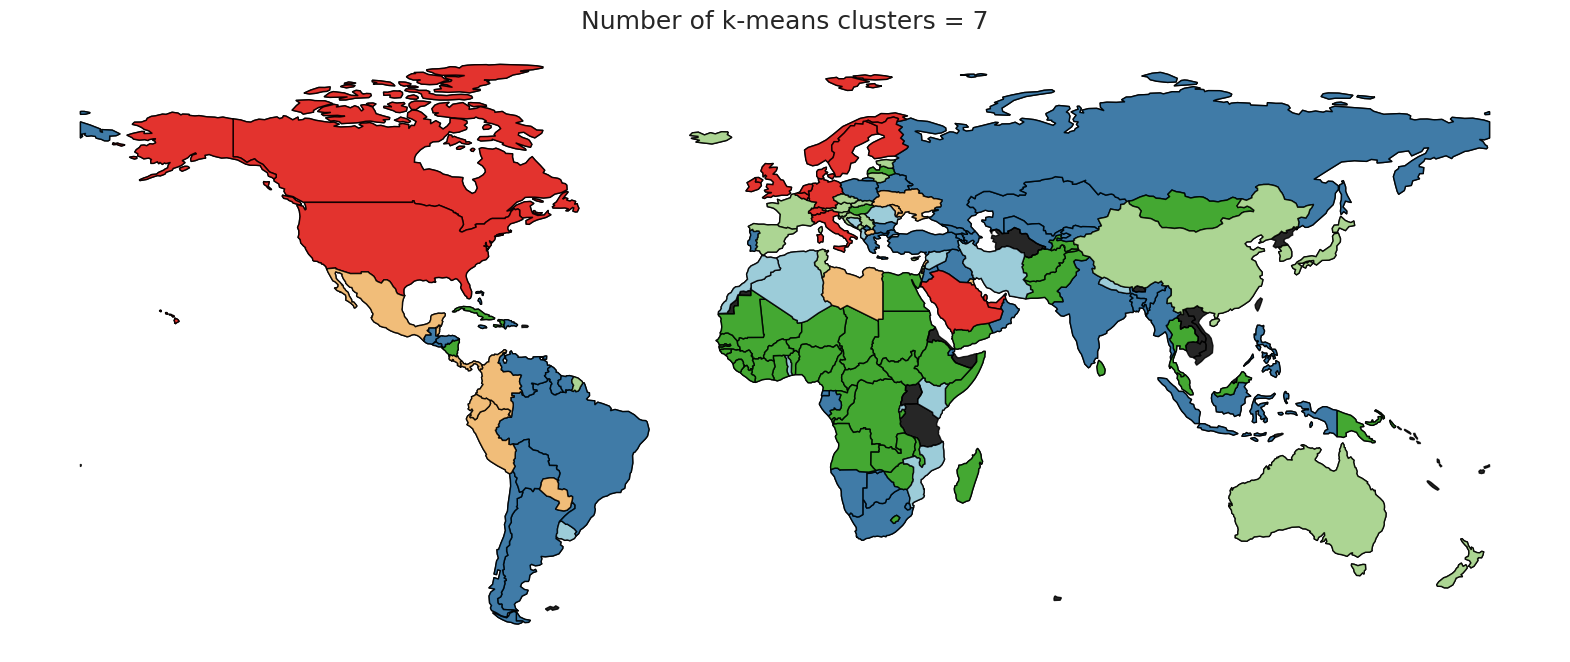

In [112]:
# Color geographical map by clusters

import matplotlib
cmap = matplotlib.cm.get_cmap('Paired')

num = 7
k = np.where(nclusters==num)[0][0]
clusters = labels_kmeans_euclidean[k]

map_cluster = {}
for cgis in countries_gis:
    ii = -1
    for i,c in enumerate(countries):
        if cgis==c:
            map_cluster[c] = clusters[i]
for cgis in countries_gis:
    if not cgis in map_cluster:
        map_cluster[cgis] = np.nan
            
list_cluster = [map_cluster[c] for c in countries_gis]
world['cluster'] = list_cluster

ax2 = world.plot(column='cluster',figsize=(20,20), edgecolor=u'black', cmap='Set2' )
for c in countries_gis:
    cl = map_cluster[c]
    if np.isnan(a):
        plotCountryPatch(ax2, c, 'white')
    else:
        plotCountryPatch(ax2, c, cmap(cl))

plt.axis('off')
plt.title('Number of k-means clusters = '+str(num))
plt.show()

In [114]:
# Produce clustering table of KMeans clustering

nums = [5,6,7]

cl_results = pd.DataFrame(data={'Country':original_names})
for n in nums:
    k = np.where(nclusters==n)[0][0]
    cl_results['Kmeans_eucl_'+str(n)] = labels_kmeans_euclidean[k]

display(cl_results)
cl_results.to_csv('output/Kmeans_3plusGDP_eucl_var4.txt',sep='\t',index=False)

Country  Kmeans_eucl_5  Kmeans_eucl_6  Kmeans_eucl_7
0    Burkina Faso              0              2              3
1         Burundi              0              2              3
2        Thailand              0              2              3
3           Niger              0              2              3
4            Chad              0              2              3
..            ...            ...            ...            ...
160        Jordan              4              1              1
161     Argentina              4              1              1
162        Poland              4              1              1
163         Qatar              4              0              5
164       Georgia              4              1              1

[165 rows x 4 columns]

151
optimal eps= 0.51 number of clusters= 4


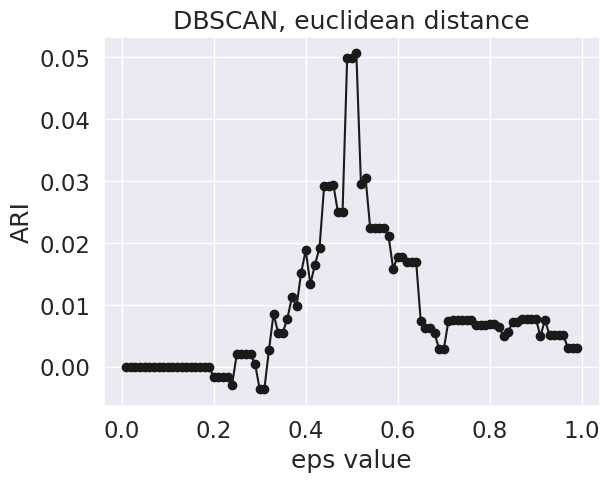

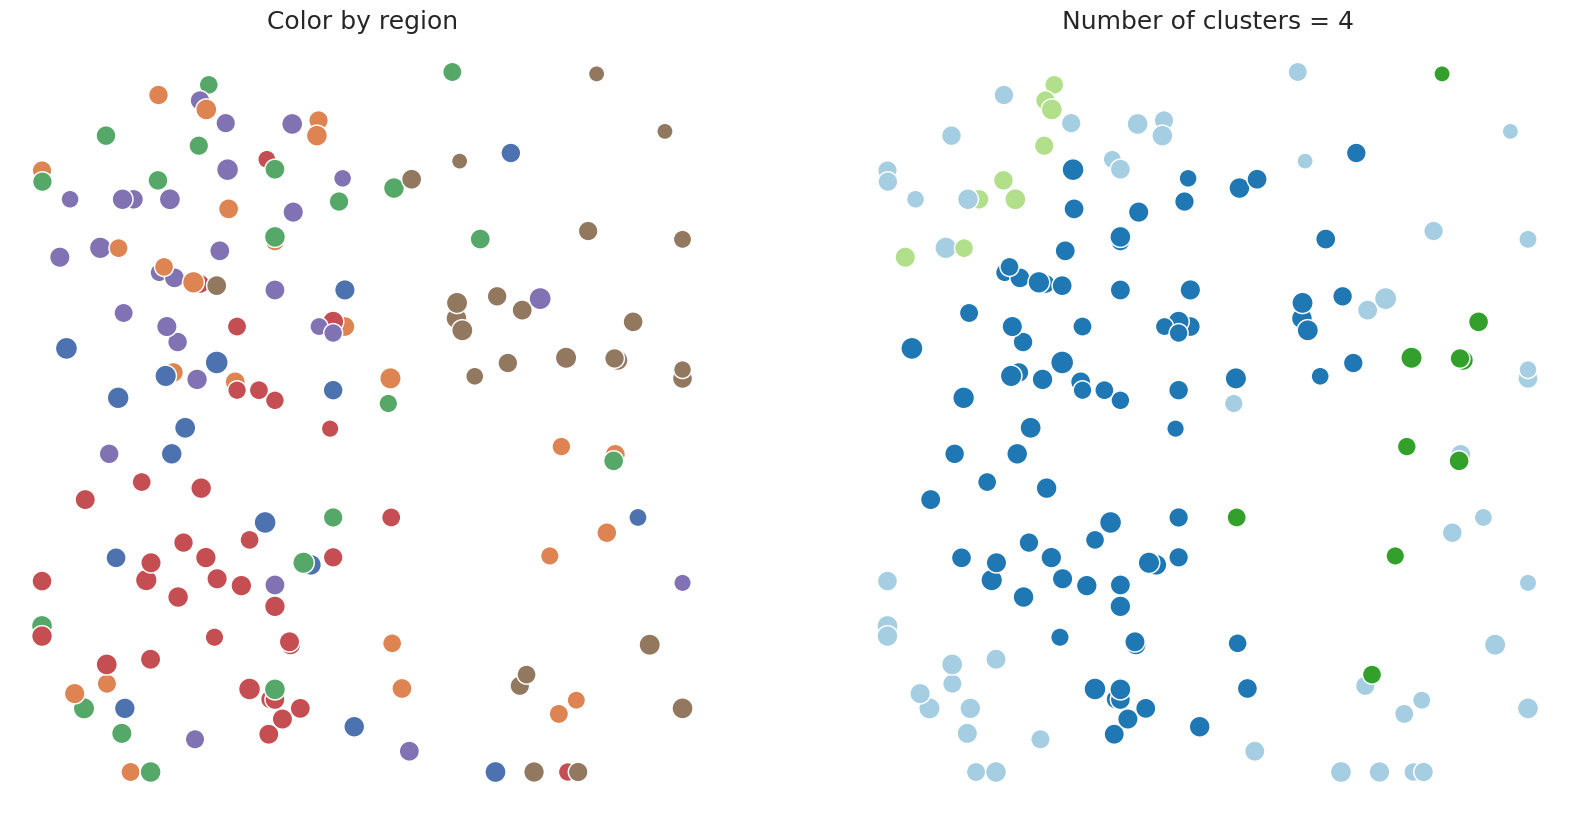

In [57]:
# Apply DBSCAN clustering

import scipy
import scipy.stats as stats
from sklearn.cluster import DBSCAN
from sklearn.metrics.cluster import adjusted_rand_score

classes = list(tab['Region'])
print(len(classes))
logpop = np.array(list(tab['log_population']))

coords = np.loadtxt('data/dataproj_4vars.vem')

X = tab[['a','K2','logq']].to_numpy()
X = stats.zscore(X)

aris_DBSCAN_euclidean = []
labels_DBSCAN_euclidean = []
eps_values = np.arange(0.01,1.0,0.01)
for eps in eps_values:
    dbscan = DBSCAN(eps=eps).fit(X)
    labels_DBSCAN_euclidean.append(dbscan.labels_)
    ari = adjusted_rand_score(classes,dbscan.labels_)
    aris_DBSCAN_euclidean.append(ari)
    
k = np.argmax(aris_DBSCAN_euclidean)
print('optimal eps=',eps_values[k],'number of clusters=',len(set(labels_DBSCAN_euclidean[k])))
    
sn.set(font_scale=1.5)
plt.plot(eps_values,aris_DBSCAN_euclidean,'ko-')
plt.xlabel('eps value')
plt.title('DBSCAN, euclidean distance')
plt.ylabel('ARI')
plt.show()

sn.set(font_scale=1.5)
fig, ax = plt.subplots(1,2,figsize=(20,10))
plt.subplot(121)
sn.scatterplot(data={'x':coords[:,0],'y':coords[:,1],'logpop':logpop,'Region':classes},x='x',y='y',hue='Region',legend=False,s=logpop*30)
plt.axis('off')
plt.title('Color by region')

plt.subplot(122)
sn.scatterplot(data={'x':coords[:,0],'y':coords[:,1],'logpop':logpop,'Region':classes,'cluster':labels_DBSCAN_euclidean[k]},x='x',y='y',hue='cluster',legend=False,s=logpop*30,palette='Paired')
plt.axis('off')
plt.title('Number of clusters = 4')


plt.show()

165


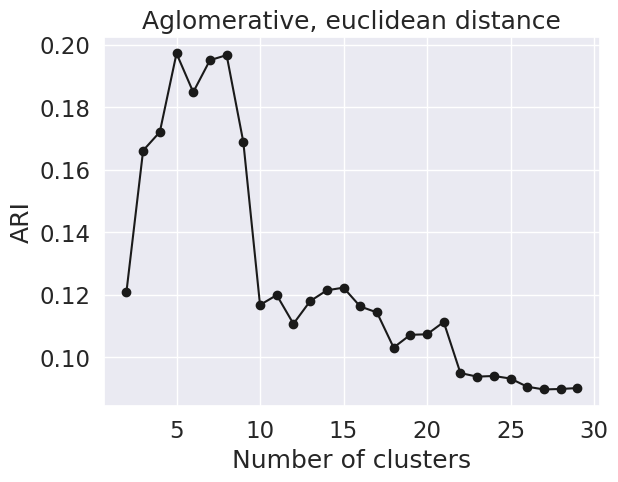

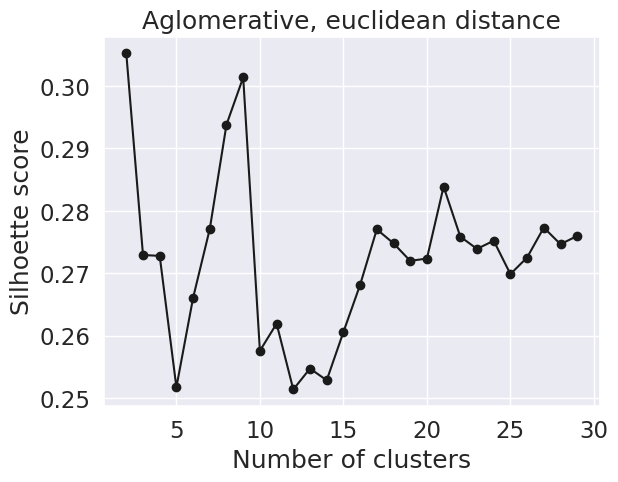

nclusters [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29]


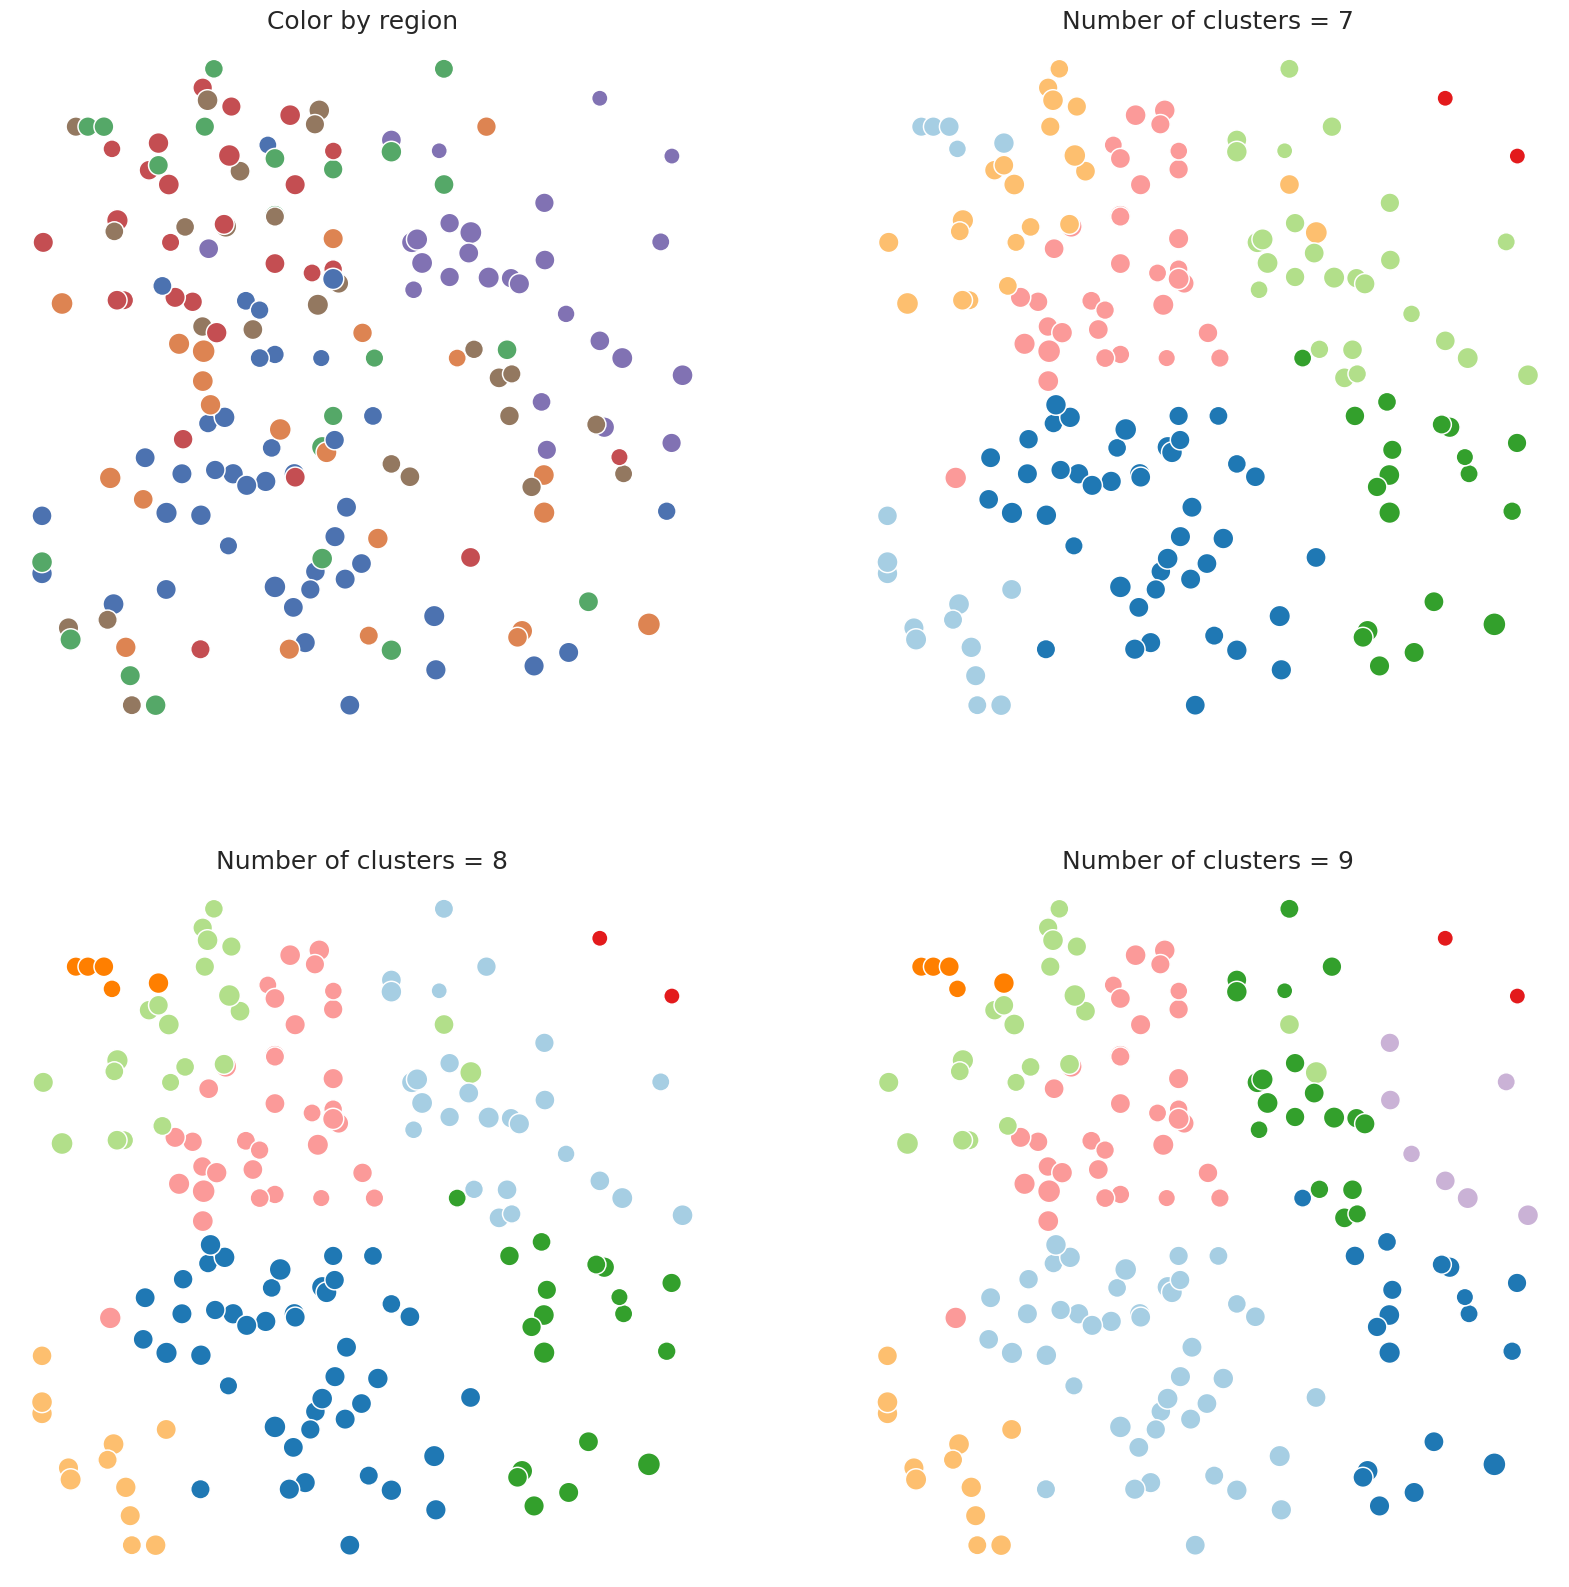

In [117]:
# Apply hierarchical clustering

import scipy
import scipy.stats as stats
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import adjusted_rand_score

classes = list(tab['Region'])
print(len(classes))
logpop = np.array(list(tab['log_population']))

#coords = np.loadtxt('/mnt/c/Datas/COVID_model/data2_proj.txt')
#X = tab[['a','K2','logq']].to_numpy()
#coords = np.loadtxt('/mnt/c/Datas/COVID_model/data1_proj.txt')
#X = tab[['a','K2','logq','Io','Ndays']].to_numpy()
coords = np.loadtxt('data/dataproj_4vars.vem')
X = tab[['a','K2','logq','GDP_per_capita_PPP']].to_numpy()



X = stats.zscore(X)
aris = []
sils = []
labels = []
nclusters = np.arange(2,30)
for nc in nclusters:
    clustering = AgglomerativeClustering(n_clusters=nc).fit(X)
    labels.append(clustering.labels_)
    ari = adjusted_rand_score(classes,clustering.labels_)
    aris.append(ari)
    sil = silhouette_score(X,clustering.labels_)
    sils.append(sil)
    
    
sn.set(font_scale=1.5)
plt.plot(nclusters,aris,'ko-')
plt.xlabel('Number of clusters')
plt.title('Aglomerative, euclidean distance')
plt.ylabel('ARI')
plt.show()

sn.set(font_scale=1.5)
plt.plot(nclusters,sils,'ko-')
plt.xlabel('Number of clusters')
plt.title('Aglomerative, euclidean distance')
plt.ylabel('Silhoette score')
plt.show()

#sn.scatterplot(data={'x':coords[:,0],'y':coords[:,1],'logpop':logpop,'Region':classes},size='logpop',color='Region')
sn.set(font_scale=1.5)
fig, ax = plt.subplots(2,2,figsize=(20,20))
plt.subplot(221)
sn.scatterplot(data={'x':coords[:,0],'y':coords[:,1],'logpop':logpop,'Region':classes},x='x',y='y',hue='Region',legend=False,s=logpop*30)
plt.axis('off')
plt.title('Color by region')

num = 7
print('nclusters',nclusters)
k = np.where(nclusters==num)[0][0]
plt.subplot(222)
sn.scatterplot(data={'x':coords[:,0],'y':coords[:,1],'logpop':logpop,'Region':classes,'cluster':labels[k]},x='x',y='y',hue='cluster',legend=False,s=logpop*30,palette='Paired')
plt.axis('off')
plt.title('Number of clusters = '+str(num))

num = 8
k = np.where(nclusters==num)[0][0]
plt.subplot(223)
sn.scatterplot(data={'x':coords[:,0],'y':coords[:,1],'logpop':logpop,'Region':classes,'cluster':labels[k]},x='x',y='y',hue='cluster',legend=False,s=logpop*30,palette='Paired')
plt.axis('off')
plt.title('Number of clusters = '+str(num))

num = 9
k = np.where(nclusters==num)[0][0]
plt.subplot(224)
sn.scatterplot(data={'x':coords[:,0],'y':coords[:,1],'logpop':logpop,'Region':classes,'cluster':labels[k]},x='x',y='y',hue='cluster',legend=False,s=logpop*30,palette='Paired')
plt.axis('off')
plt.title('Number of clusters = '+str(num))

plt.show()

/tmp/ipykernel_270/695737914.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Paired')


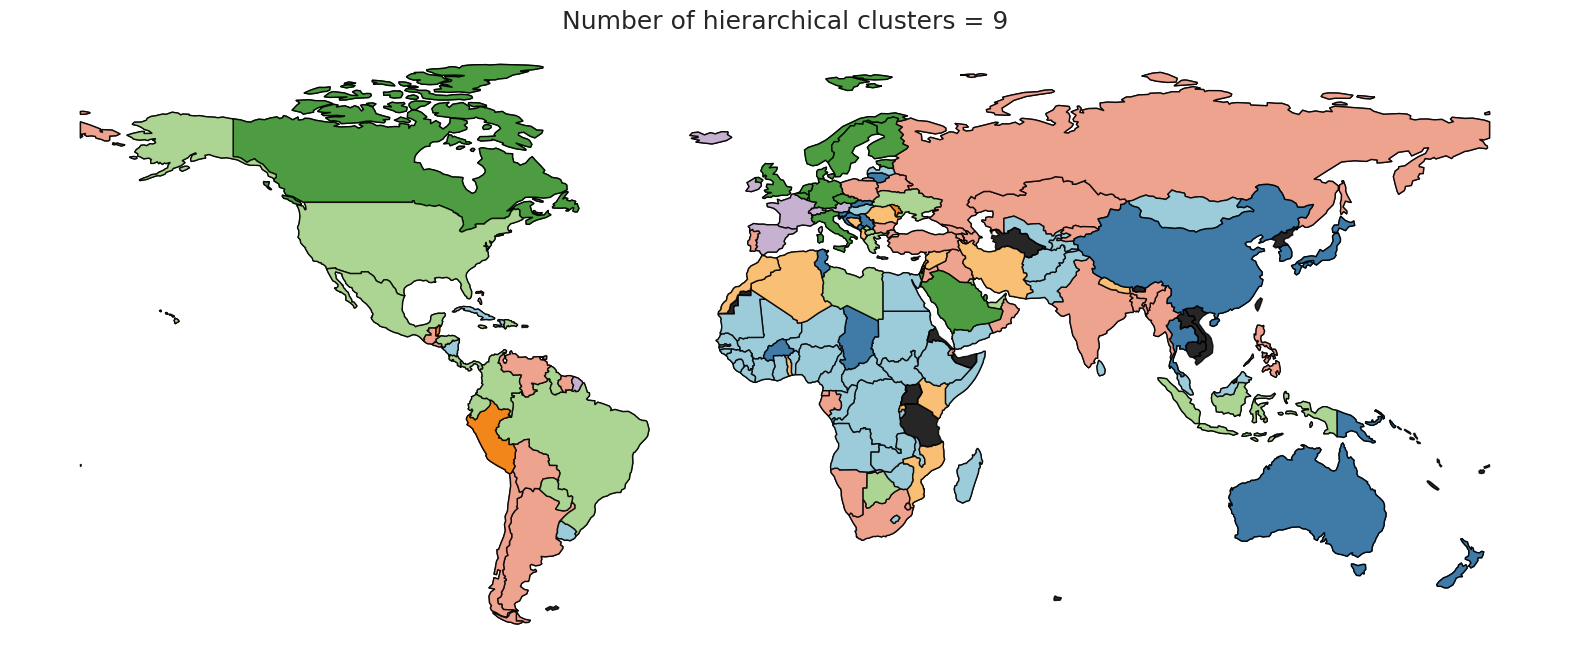

In [118]:
# Color the map using hierarchical clustering

import matplotlib
cmap = matplotlib.cm.get_cmap('Paired')

num = 9
k = np.where(nclusters==num)[0][0]
clusters = labels[k]

map_cluster = {}
for cgis in countries_gis:
    ii = -1
    for i,c in enumerate(countries):
        if cgis==c:
            map_cluster[c] = clusters[i]
for cgis in countries_gis:
    if not cgis in map_cluster:
        map_cluster[cgis] = np.nan
            
list_cluster = [map_cluster[c] for c in countries_gis]
world['cluster'] = list_cluster

ax2 = world.plot(column='cluster',figsize=(20,20), edgecolor=u'black', cmap='Set2' )
for c in countries_gis:
    cl = map_cluster[c]
    if np.isnan(a):
        plotCountryPatch(ax2, c, 'white')
    else:
        plotCountryPatch(ax2, c, cmap(cl))

plt.axis('off')
plt.title('Number of hierarchical clusters = '+str(num))
plt.show()

In [119]:
# Produce table of hierarchical clusters

nums = [6,7,8,9]

cl_results = pd.DataFrame(data={'Country':original_names})
for n in nums:
    k = np.where(nclusters==n)[0][0]
    cl_results['Aglomerative_eucl_'+str(n)] = labels_kmeans_euclidean[k]

display(cl_results)
cl_results.to_csv('output/Aglomerative_eucl_var4.txt',sep='\t',index=False)

Country  Aglomerative_eucl_6  Aglomerative_eucl_7  \
0    Burkina Faso                    2                    3   
1         Burundi                    2                    3   
2        Thailand                    2                    3   
3           Niger                    2                    3   
4            Chad                    2                    3   
..            ...                  ...                  ...   
160        Jordan                    1                    1   
161     Argentina                    1                    1   
162        Poland                    1                    1   
163         Qatar                    0                    5   
164       Georgia                    1                    1   

     Aglomerative_eucl_8  Aglomerative_eucl_9  
0                      7                    2  
1                      7                    2  
2                      7                    2  
3                      7                    2  
4                      7                    2  
..                   ...                  ...  
160                    1                    8  
161                    1                    8  
162                    1                    8  
163                    5                    0  
164                    1                    8  

[165 rows x 5 columns]

151


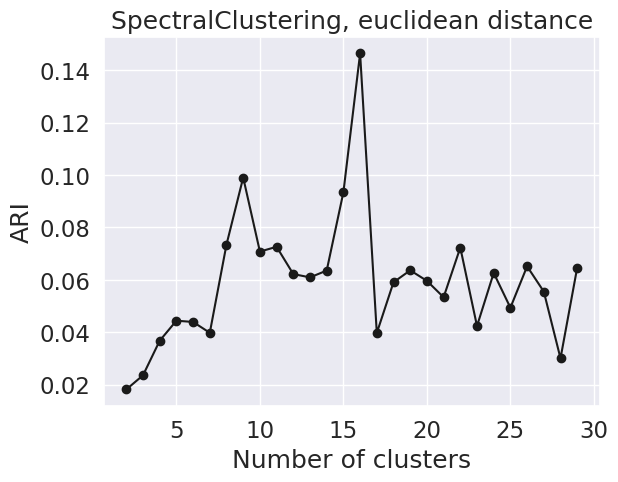

nclusters [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29]


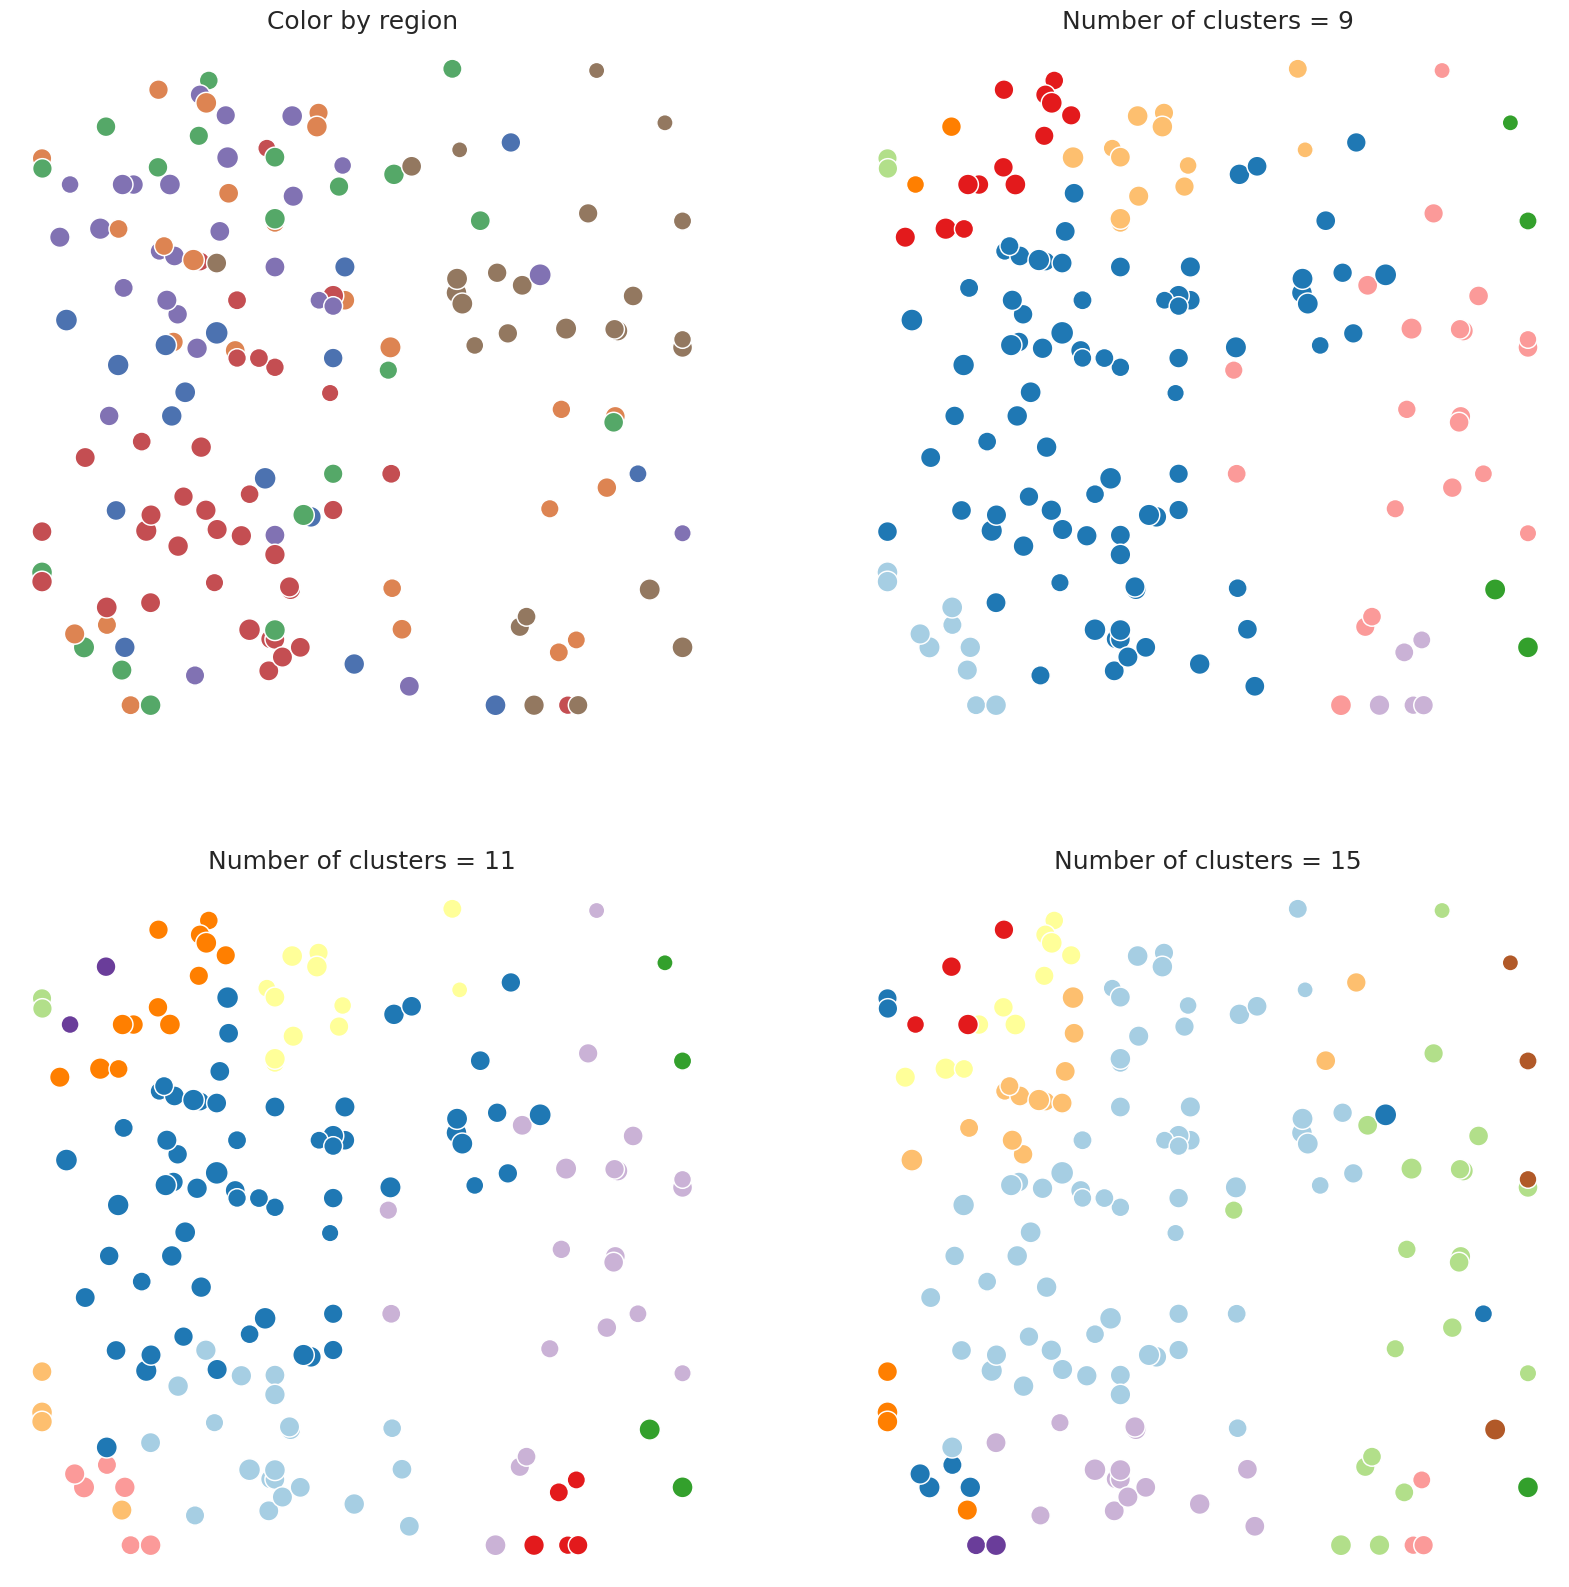

In [63]:
# Apply spectral clustering

import scipy
import scipy.stats as stats
from sklearn.cluster import SpectralClustering
from sklearn.metrics.cluster import adjusted_rand_score

classes = list(tab['Region'])
print(len(classes))
logpop = np.array(list(tab['log_population']))

coords = np.loadtxt('data/data3_proj.txt')

X = tab[['a','K2','logq']].to_numpy()
X = stats.zscore(X)
aris = []
labels = []
nclusters = np.arange(2,30)
for nc in nclusters:
    clustering = SpectralClustering(n_clusters=nc,random_state=0).fit(X)
    labels.append(clustering.labels_)
    ari = adjusted_rand_score(classes,clustering.labels_)
    aris.append(ari)
    
sn.set(font_scale=1.5)
plt.plot(nclusters,aris,'ko-')
plt.xlabel('Number of clusters')
plt.title('SpectralClustering, euclidean distance')
plt.ylabel('ARI')
plt.show()

#sn.scatterplot(data={'x':coords[:,0],'y':coords[:,1],'logpop':logpop,'Region':classes},size='logpop',color='Region')
sn.set(font_scale=1.5)
fig, ax = plt.subplots(2,2,figsize=(20,20))
plt.subplot(221)
sn.scatterplot(data={'x':coords[:,0],'y':coords[:,1],'logpop':logpop,'Region':classes},x='x',y='y',hue='Region',legend=False,s=logpop*30)
plt.axis('off')
plt.title('Color by region')

num = 9
print('nclusters',nclusters)
k = np.where(nclusters==num)[0][0]
plt.subplot(222)
sn.scatterplot(data={'x':coords[:,0],'y':coords[:,1],'logpop':logpop,'Region':classes,'cluster':labels[k]},x='x',y='y',hue='cluster',legend=False,s=logpop*30,palette='Paired')
plt.axis('off')
plt.title('Number of clusters = '+str(num))

num = 11
k = np.where(nclusters==num)[0][0]
plt.subplot(223)
sn.scatterplot(data={'x':coords[:,0],'y':coords[:,1],'logpop':logpop,'Region':classes,'cluster':labels[k]},x='x',y='y',hue='cluster',legend=False,s=logpop*30,palette='Paired')
plt.axis('off')
plt.title('Number of clusters = '+str(num))

num = 15
k = np.where(nclusters==num)[0][0]
plt.subplot(224)
sn.scatterplot(data={'x':coords[:,0],'y':coords[:,1],'logpop':logpop,'Region':classes,'cluster':labels[k]},x='x',y='y',hue='cluster',legend=False,s=logpop*30,palette='Paired')
plt.axis('off')
plt.title('Number of clusters = '+str(num))

plt.show()

/tmp/ipykernel_12895/3639728704.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Paired')


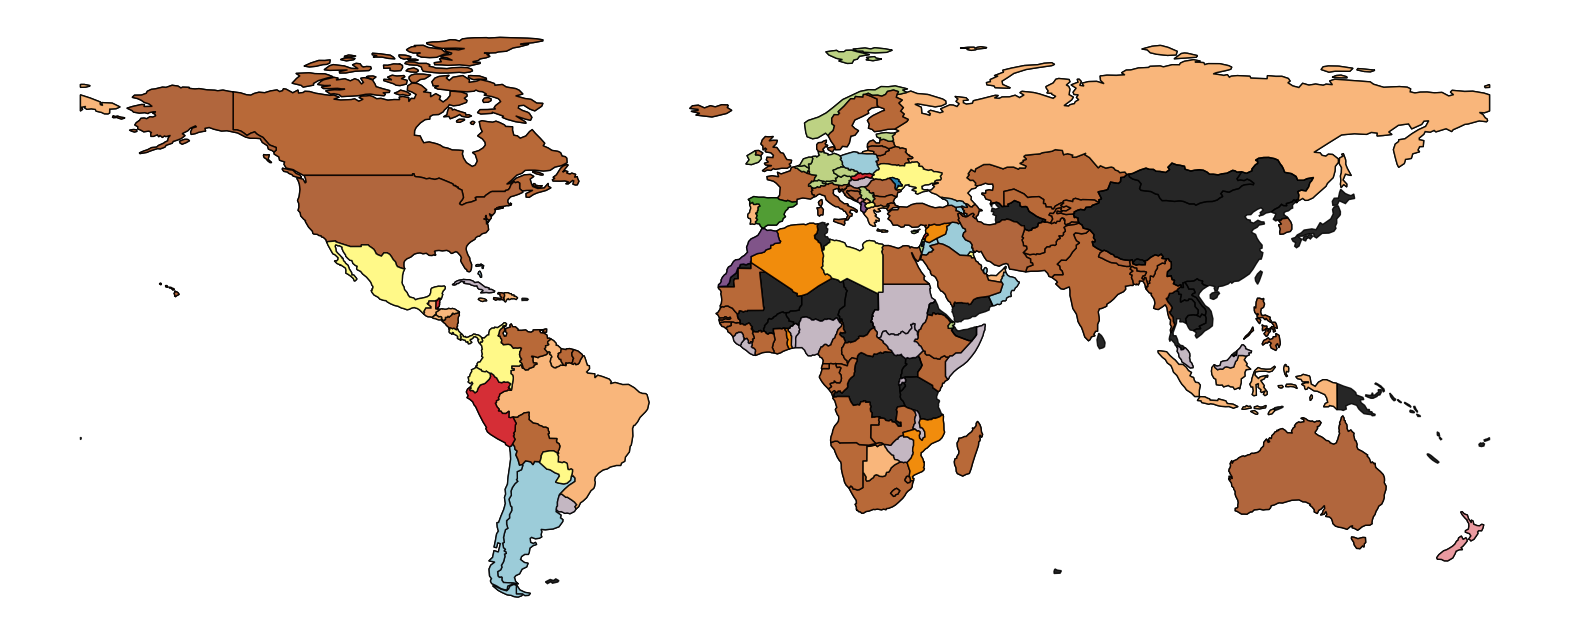

In [64]:
# Plot spectral clusters

import matplotlib
cmap = matplotlib.cm.get_cmap('Paired')

num = 15
k = np.where(nclusters==num)[0][0]
clusters = labels[k]

map_cluster = {}
for cgis in countries_gis:
    ii = -1
    for i,c in enumerate(countries):
        if cgis==c:
            map_cluster[c] = clusters[i]
for cgis in countries_gis:
    if not cgis in map_cluster:
        map_cluster[cgis] = np.nan
            
list_cluster = [map_cluster[c] for c in countries_gis]
world['cluster'] = list_cluster

ax2 = world.plot(column='cluster',figsize=(20,20), edgecolor=u'black', cmap='Set2' )
for c in countries_gis:
    cl = map_cluster[c]
    if np.isnan(a):
        plotCountryPatch(ax2, c, 'white')
    else:
        plotCountryPatch(ax2, c, cmap(cl))

plt.axis('off')
plt.show()

In [68]:
# Produce table of spectral clusters

nums = [9,11,15]

cl_results = pd.DataFrame(data={'Country':original_names})
for n in nums:
    k = np.where(nclusters==n)[0][0]
    cl_results['Spectral_eucl_'+str(n)] = labels_kmeans_euclidean[k]

display(cl_results)
cl_results.to_csv('output/Spectral_eucl.txt',sep='\t',index=False)

Country  Spectral_eucl_9  Spectral_eucl_11  Spectral_eucl_15
0    Afghanistan                8                 3                 7
1        Albania                6                 0                 1
2        Algeria                6                 0                 1
3         Angola                8                 3                 7
4      Argentina                2                 1                 0
..           ...              ...               ...               ...
146      Uruguay                6                 0                 8
147   Uzbekistan                1                 5                 7
148    Venezuela                1                 5                 4
149       Zambia                8                 3                 7
150     Zimbabwe                8                 3                 8

[151 rows x 4 columns]